# Assessment of Integrated MV-LV OE Calculations to Orchestrate DERs
# OE Algorithm 3: Asset Capacity & Critical Voltage

## 1. Introduction
This work is part of the project [Accelerating the Implementation of Operating Envelopes Across Australia](https://electrical.eng.unimelb.edu.au/power-energy/projects/accelerating-the-implementation-of-operating-envelopes-across-australia) funded by CSIRO. This project provided key metrics, recommendations, and guidance for distribution companies (known as Distribution Network Service Providers [DNSPs] in Australia) and AEMO (the Australian system operator) to assist them in improving and, hence, accelerating the use of Operating Envelopes (OEs) across Australia.

> <span style="color:purple">**What are Operating Envelopes (OEs)?** OEs are time-varying export or import limits calculated in real time or in advance at the connection point of the customer to ensure the integrity of the distribution network (i.e., customer voltages within limits and no asset congestion). The OEs are calculated only for customers with flexible connection agreements (called here *flexible customers*). Customers with conventional connection agreements (called here *fixed customers*) do not require OEs.</span>

**This interactive notebook demonstrates the process to implement the *Asset Capacity & Critical Voltage OE Algorithm with Integrated MV-LV Calculations*** produced by The University of Melbourne. This demonstration is useful for different stakeholders (e.g., DNSPs, AEMO, CSIRO, regulators, consultancy companies, technology providers) as it can help them familiarise with the corresponding algorithm and the required inputs as well as the pros and cons.

> <span style="color:purple">The **Asset Capacity & Critical Voltage (AC_CrV) OE with Integrated MV-LV Calculations** is an intermediate approach - it is more advanced than the Asset Capacity OE as both voltage and thermal aspects are considered, but less advanced than the Ideal OE - that is still relatively simple to be implemented since it does not need network models and only an extra monitoring (e.g., smart meter, temporary network meter) at the critical customer when compared to the Asset Capcity OE. In this OE approach, thermal issues are solved by estimating the spare capacity of MV and LV networks, while voltages issues are solved by estimating the voltage (using simple P-V sensitivity curves) at the critical customer of each LV network. </span>
> - Monitoring: At MV and LV head of feeders (P, Q, and V, all per phase), and at the critical customer of each LV network (net demand P, and voltage magnitude V).
> - Electrical models: None.

## 2. Algorithm Overview
The **AC_CrV OE with Integrated MV-LV Calculations** requires a P-V sensitivity curve that is used to estimate the voltage at the critical customer from its net active power demand. This P-V sensitivity curve can be obtained beforehand with historical data from the critical customer, and it can be used for every time step since the sensitivity curve is unlikely to change within short periods. Note that each LV network will have its own P-V sensitivity curve. To obtain this P-V sensitivity curve for a given LV network:
- Take the historical net active power demand and voltages of the corresponding critical customer for a given period (e.g., two days), and use them as input to a polynomial fit function from a standard library (e.g., Python NumPy) to create the P-V sensitivity curve. Note that the used polynomial function is of first degree, creating a linear sensitivity curve.

Once the required sensitivity curves are available, the AC_CrV OE algorithm first estimates the spare capacity of each LV network by using the distribution transformer and LV head of feeder utilisations, then proportionally allocate the spare capacity among flexible customers (this allocated spare capacity is called here as the temporary OE value). Second, the allocated spare capacity in each LV network must be aggregated to assess the thermal limits of the MV network, and reductions on the current temporary OE values are made if necessary. The third step consists on using the P-V sensitivity curve of each LV network to estimate the critical customer voltage according to the temporary OE value of the corresponding LV network. If the voltage of the corresponding critical customer is beyond the limit, the temporary OE value of the given LV network is reduced and the voltage re-estimated and re-assessed. This repeats until no voltage problem is expected for each and every LV networks. Note that for calculations in advance (e.g., hours ahead), forecasting capabilities are also needed (however, here, perfect forecasting is used for simplicity).

For a given point in time (e.g., at 12:00PM), the high-level steps of the algorithm are as follows:
1. **Obtain the estimated aggregated fixed customer net demand for each LV network**. This value is obtained by subtracting the estimated aggregated flexible customer net demand from the distribution transformer demand (which includes all customers) of a given LV network. This is carried out for each LV network. Note that sign convention and direction of power flows have to be adequately considered since one can be importing and the other exporting power depending on the time of the day. 
2. **Calculate the spare capacity of each LV network for OE exports (or OE imports)**. This value is obtained by subtracting the estimated aggregated fixed customer net demand from the rated capacity of the distribution transformer of a given LV network. Then this initial spare capacity is checked against the given LV HoF rated capacity, which is reduced if above HoF limits. This is carried out for each LV network. Note that sign convention and direction of power flows have to be adequately considered as the spare capacity will be different for exports and imports.
3. **Check if spare capacity is available in each LV network for OE exports (or OE imports)**. If there is spare capacity available in a given LV network, proceed to step 4. Otherwise, the calculated OE value to all flexible customers of the given LV network is equal to zero, thus proceed to the next LV network and re-run step 3.
4. **Allocate the spare capacity in each LV network for OE exports (or OE imports)**. Proportionally divide (based on the corresponding installed DER size) the spare capacity among all flexible customers of a given LV network. This allocated spare capacity to each flexible customer is a temporary OE value (P') for the given LV network. If there are still LV networks that were not checked, proceed to step 3 and to the next LV network. Otherwise, proceed to step 5. 
5. **Check if the MV network is OK considering the temporary OE values for exports (or imports)** Aggregate the temporary OE value of all flexible customers (from all LV networks) and check against the rated capacity of the MV HoF. If whithin its limit, proceed to step 6. Otherwise, equally reduce the current temporary OE value of all flexible customers (from all LV networks) to fit the MV HoF capacity, and proceed to step 6.
6. **Estimate the voltage at the critical customer of each LV network for OE exports (or OE imports)**. For each LV network, use the temporary OE value (P') for the critical customer and the corresponding P-V sensitivity curve to estimate the voltage magnitude (V') at this customer. This is carried out for each LV network.
7. **Check for voltage problems at the critical customer of each LV network for OE exports (or OE imports)**. If the estimated voltage at a given critical customer breaches the network limit, reduce the temporary OE value (P') of the correspondning LV network by a pre-defined value (e.g., reduce by 1% of the original value), and go back to step 6. Otherwise, the temporary OE values correspond to the OE exports (or imports) for flexible customers, thus proceed to step 8.
8. **Move to the next time step (e.g., 12:05PM) and restart the process from step 1.**

<span style="color:red">**<u>Note 1</u>.</span>** The OE exports and OE imports are calculated separately. When calculating exports, all flexible customers are considered to export. When calculating imports, all flexible customers are considered to import. This ensures the asset integrity even if all flexible customers operate at their maximum allocated OE capacity (worst case scenario).

<span style="color:red">**<u>Note 2</u>.</span>** The estimated aggregated fixed customer net demand in step 1 can also be obtained in other ways. For instance, if the DNSP has 100% smart meter penetration and forecast for all customers, the net demand of fixed customers can be simply summed.

<span style="color:red">**<u>Note 3</u>.</span>** Network losses are not being considered here, but it should be simple to add to the algorithm.

<span style="color:red">**<u>Note 4</u>.</span>** For OE calculations in real-time no forecast is needed, real-time measurements from the network/customers should be used instead.

<span style="color:red">**<u>Note 5</u>.</span>** The OE values are calculated for the active power only. The reactive power of PV systems are considered to be zero all the time.

<span style="color:red">**<u>Note 6</u>.</span>** The LV head of feeder utilisation is approximated via a simplified approach, where flexible customers are considered to be equally divided among feeders and phases, thus it still allows thermal problems to happen in LV feeders.

## 3. Inputs and Outputs for the OE Calculation Algorithm
### Time-Varying Inputs
- Historical voltage magnitude (V) of the critical flexible customer of each LV network.
- Historical net active power demand (P) of the critical flexible customer of each LV network.
- Forecasted aggregated flexible customer net demand (P, Q) of each LV network.
- Forecasted distribution transformer demand (P, Q) of each LV network.
- Forecasted voltage magnitude (V) at the MV head of feeder.
- Forecasted voltage magnitude (V) at LV head of feeders of each LV network.
- Forecasted current magnitude (I) at LV head of feeders of each LV network.

### Static Inputs
- Rated capacity of the MV head of feeder.
- Rated capacity of the distribution transformer of each LV network.
- Rated capacity of LV head of feeders of each LV network.
- Number of flexible customers at each LV network.
- DER installed capacity of flexible customers.

### Outputs
- The OEs for exports and imports. 

## 4. Test MV-LV Network
A real 22kV MV feeder from Victoria, Australia, with 79 distribution transformers is used to demonstrate the OE algorithm, as shown in Figure 1. This integrated MV-LV network has the following characteristics:
- One 3-phase MV feeder (22kV)
- 79 distribution transformers (22kV/0.433kV)
- 3,374 single-phase-connected residential customers (distributed along 70 distribution transformers)
- 9 C&I customers (on the other 9 distribution transformers)

The following scenario is considered:
- 1,856 residential customers (~55% of total) are considered fixed customers without PV systems.
- 1,012 residential customers (~30% of total) are considered fixed customers with PV systems.
- 506 residential customers (~15% of total) are flexible customers.
- Fixed customers with PV systems have installed capacity ranging from 1.25kVA to 11.75kVA (based on Australian stats from 2020-2022). Their PV systems also have the combined Volt-Watt and Volt-Var functions enabled (as per Australian Standards).
- Flexible customers have PV systems with installed capacity ranging from 1.25kVA to 11.75kVA (based on Australian stats from 2022-2023). These customers do not have their combined Volt-Watt and Volt-Var functions enabled since, in this project, it is considered that the calculated OE value should guarantee the network integrity. 
- Customer demands and PV irradiance are from the summer of 2014 in Victoria, Australia.
- The simulation is carried out for three days.

<span style="color:red">**<u>Note</u>.</span>** To speed up the simulation, the default of the code is to simulate only 2h of the first day. This can be changed to the original three complete days if you want, just follow the instructions along the Jupyter notebook.

<img style="float: middle;" src="MV_feeder.SVG" width="100%">

**<center>Figure 1. 22kV MV feeder with 79 distribution transformers</center>**

## 5. interactive Code
<span style="color:red">**<u>Note 1</u>.</span>** This interactive notebook is designed to facilitate the learning/teaching of the content. Therefore, the definitions of functions are not made at the beginning of the notebook as it is usually done when just coding.

<span style="color:red">**<u>Note 2</u>.</span>** We suggest you to turn on line numbers for your Jupyter notebook. To do so, in the Jupyter notebook menu (top of the page), click on "View", then click on "Toggle Line Numbers". This will be useful for instructions to come.

### 5.1. Initialisation of Libraries

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import copy
import dss

### 5.2. Get Directory and Initialise OpenDSS

In [2]:
# Get directory location
mydir = os.getcwd()

# Initialise the OpenDSS (this allows to run the power flows later)
dss_engine = dss.DSS
dss_text = dss_engine.Text                                                      
dss_circuit = dss_engine.ActiveCircuit                                            
dss_solution = dss_engine.ActiveCircuit.Solution                                      
control_queue = dss_engine.ActiveCircuit.CtrlQueue                                          
dss_engine.AllowForms = 0

### 5.3. Load/Prepare Necessary Inputs
Load the necessary inputs to calculate the Asset Capacity & Critical Voltage OE.

In [3]:
# Define time resolution of the data
time_resolution = 5 # in minutes

# Define number of time steps in the day (24h) for the corresponding time resolution
num_time_steps = 288

# Set number of distribution transformers
num_distr_tx = 79

# Set number of days to be simulated
num_days = 3

# Name of all flexible customers in the integrated MV-LV networks separated by LV network
all_flex_cust_names_per_lv = np.load(mydir + '/simulation_files/scenario/scenario2_flex_cust_names.npy', allow_pickle=True) 

# Capacity of each distribution transformer of the integrated MV-LV networks separated by LV network
all_lvtx_capacity = np.load(mydir + '/simulation_files/lvtx_capacity.npy')   

# DER size of all flexible customers in the integrated MV-LV network separated by LV network
all_flex_cust_der_size = np.load(mydir + '/simulation_files/scenario/scenario2_lv_flex_cust_der_size.npy', allow_pickle=True)

# Number of LV feeder per LV network
lv_total_feeders = np.load(mydir + '/simulation_files/lv_total_feeders.npy')

# Estimated/Forecasted aggregated flexible customer net demand in each LV network of the integrated MV-LV network
agg_net_p_flex_cust = np.load(mydir + '/simulation_files/scenario/scenario2_summer_agg_net_p_flex_cust.npy') # active power
agg_net_q_flex_cust = np.load(mydir + '/simulation_files/scenario/scenario2_summer_agg_net_q_flex_cust.npy') # reactive power

# Forecasted distribution transformer power in each LV network of the integrated MV-LV network
lvtx_p = np.load(mydir + '/simulation_files/scenario/scenario2_summer_power_p_lv_tx.npy') # active power
lvtx_q = np.load(mydir + '/simulation_files/scenario/scenario2_summer_power_q_lv_tx.npy') # reactive power

# Forecasted LV HoF currents and voltages in each LV network of the integrated MV-LV network
lv_hof_currents = np.load(mydir + '/simulation_files/scenario/scenario2_summer_all_lv_hof_currents.npy', allow_pickle=True).item() # currents
lv_hof_voltages = np.load(mydir + '/simulation_files/scenario/scenario2_summer_all_lv_hof_voltages.npy', allow_pickle=True).item() # voltages

# Forecasted MV HoF currents and voltages on the integrated MV-LV network
hv_hof_currents = np.load(mydir + '/simulation_files/scenario/scenario2_summer_all_hv_hof_currents.npy') # currents
hv_hof_voltages = np.load(mydir + '/simulation_files/scenario/scenario2_summer_all_hv_hof_voltages.npy') # voltages

# Rated capacity of MV and LV HoFs on the integrated MV-LV network
lv_hof_currents_capacity = np.load(mydir + '/simulation_files/all_lv_hof_currents_capacity.npy') # LV HoFs rated capacity
hv_hof_current_capacity = np.load(mydir + '/simulation_files/all_hv_hof_current_capacity.npy') # MV HoF rated capacity

# Historical voltage magnitude of the critical customer of each LV network of the integrated MV-LV network
hist_voltage_crit_cust = np.load(mydir + '/simulation_files/scenario/scenario2_hist_flex_crit_cust_voltage.npy')

# Historical net active power of the critical customer of each LV network of the integrated MV-LV network
hist_net_p_crit_cust = np.load(mydir + '/simulation_files/scenario/scenario2_hist_flex_crit_cust_net_power_p.npy') 
    
# Name of the critical customer of each LV network of the integrated MV-LV network
name_crit_cust_per_lv = np.load(mydir + '/simulation_files/scenario/scenario2_flex_crit_cust_name.npy')

# Calculate the forecasted distribution transformers demand (apparent power, S)
lvtx_s = np.zeros((num_distr_tx, num_time_steps*num_days), float)
for itx in range(num_distr_tx): # loop to iterate through every distribution transformer of the integrated MV-LV network
    for itime in range(num_time_steps*num_days): # loop through all time steps of the simulation
        if lvtx_p[itx, itime] < 0: # importing power (load)
            lvtx_s[itx, itime] = -1 * np.sqrt(lvtx_p[itx, itime]**2 + lvtx_q[itx, itime]**2)
        if lvtx_p[itx, itime] > 0: # exporting power (generation)
            lvtx_s[itx, itime] = np.sqrt(lvtx_p[itx, itime]**2 + lvtx_q[itx, itime]**2)

# Calculate the aggregated flex customer net demand (apparent power, S)
agg_net_s_flex_cust = np.zeros((num_distr_tx, num_time_steps*num_days), float)
for itx in range(num_distr_tx): # loop to iterate through every distribution transformer of the integrated MV-LV network
    for itime in range(num_time_steps*num_days): # loop through all time steps of the simulation
        if agg_net_p_flex_cust[itx, itime] < 0: # importing power (load)
            agg_net_s_flex_cust[itx, itime] = -1 * np.sqrt(agg_net_p_flex_cust[itx, itime]**2 + agg_net_q_flex_cust[itx, itime]**2)
        if agg_net_p_flex_cust[itx, itime] > 0: # exporting power (generation)
            agg_net_s_flex_cust[itx, itime] = np.sqrt(agg_net_p_flex_cust[itx, itime]**2 + agg_net_q_flex_cust[itx, itime]**2)

# Calculate the aggregated fixed customer net demand (apparent power, S)
agg_net_s_fix_cust = np.zeros((num_distr_tx, num_time_steps*num_days), float)
for itx in range(num_distr_tx): # loop to iterate through every distribution transformer of the integrated MV-LV network
    if all_flex_cust_names_per_lv[itx]: # check if there is any flexible customer in the LV network
        for itime in range(num_time_steps*num_days): # loop through all time steps of the simulation
            agg_net_s_fix_cust[itx, itime] = lvtx_s[itx, itime] - agg_net_s_flex_cust[itx, itime]
                
# Calculate the spare capacity (kVA) of distribution transformers     
lvtx_spare_capacity_exp = np.zeros((num_distr_tx, num_time_steps*num_days), float)
lvtx_spare_capacity_imp = np.zeros((num_distr_tx, num_time_steps*num_days), float)
for itx in range(num_distr_tx): # loop to iterate through every distribution transformer of the integrated MV-LV network
    for itime in range(num_time_steps*num_days): # loop to iterate through all time steps of the simulation
        lvtx_spare_capacity_exp[itx, itime] = all_lvtx_capacity[itx] - agg_net_s_fix_cust[itx, itime] # OE exports
        lvtx_spare_capacity_imp[itx, itime] = all_lvtx_capacity[itx] + agg_net_s_fix_cust[itx, itime] # OE imports

# Calculate the estimated aggregated current of all fixed customers in a LV feeder per phase
Iagg_est_fix_cust_per_feeder_exp = {}
Iagg_est_fix_cust_per_feeder_imp = {}
for ilv in lv_hof_currents.keys(): # loop to iterate through every LV network of the integrated MV-LV network
    Iagg_est_fix_cust_per_feeder_exp[ilv] = {}
    Iagg_est_fix_cust_per_feeder_imp[ilv] = {}
    for ifd in lv_hof_currents[ilv].keys(): # loop to iterate through every feeder of the LV network
        Iagg_est_fix_cust_per_feeder_exp[ilv][ifd] = {}
        Iagg_est_fix_cust_per_feeder_imp[ilv][ifd] = {}
        Iagg_phA_est_fix_cust_exp_temp = []
        Iagg_phB_est_fix_cust_exp_temp = []
        Iagg_phC_est_fix_cust_exp_temp = []
        Iagg_phA_est_fix_cust_imp_temp = []
        Iagg_phB_est_fix_cust_imp_temp = []
        Iagg_phC_est_fix_cust_imp_temp = []
        for itime in range(num_time_steps*num_days): # loop to iterate through all time steps of the simulation
            # check if Phase A is being used, so to calculate the estimated aggregated current of all fixed customers in a LV feeder
            if sum(lv_hof_currents[ilv][ifd]['PhaseA']) == 0: 
                pass
            else:    
                # For OE exports 
                Iagg_phA_est_fix_cust_exp_temp.append(lv_hof_currents[ilv][ifd]['PhaseA'][itime] - 
                                                   ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                     agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                     lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseA'][itime])))
                # For OE imports 
                if lvtx_s[int(ilv.strip('lv')), itime] < 0: # LV network importing power (load)
                    Iagg_phA_est_fix_cust_imp_temp.append(-1 * (lv_hof_currents[ilv][ifd]['PhaseA'][itime] - 
                                                  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                    agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                    lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseA'][itime]))))
                if lvtx_s[int(ilv.strip('lv')), itime] > 0: # LV network exporting power (generation)
                    Iagg_phA_est_fix_cust_imp_temp.append(lv_hof_currents[ilv][ifd]['PhaseA'][itime] + 
                                                  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                    agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                    lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseA'][itime])))
            # check if Phase B is being used, so to calculate the estimated aggregated current of all fixed customers in a LV feeder
            if sum(lv_hof_currents[ilv][ifd]['PhaseB']) == 0:
                pass
            else:
                # For OE exports
                Iagg_phB_est_fix_cust_exp_temp.append(lv_hof_currents[ilv][ifd]['PhaseB'][itime] - 
                                                   ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                     agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                     lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseB'][itime])))
                # For OE imports 
                if lvtx_s[int(ilv.strip('lv')), itime] < 0: # LV network importing power (load)
                    Iagg_phB_est_fix_cust_imp_temp.append(-1 * (lv_hof_currents[ilv][ifd]['PhaseB'][itime] - 
                                                  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                    agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                    lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseB'][itime]))))
                if lvtx_s[int(ilv.strip('lv')), itime] > 0: # LV network exporting power (generation)
                    Iagg_phB_est_fix_cust_imp_temp.append(lv_hof_currents[ilv][ifd]['PhaseB'][itime] + 
                                                  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                    agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                    lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseB'][itime])))
            # check if Phase C is being used, so to calculate the estimated aggregated current of all fixed customers in a LV feeder
            if sum(lv_hof_currents[ilv][ifd]['PhaseC']) == 0:
                pass
            else:
                # For OE exports 
                Iagg_phC_est_fix_cust_exp_temp.append(lv_hof_currents[ilv][ifd]['PhaseC'][itime] - 
                                                   ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                     agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                     lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseC'][itime])))
                # For OE imports 
                if lvtx_s[int(ilv.strip('lv')), itime] < 0: # LV network importing power (load)
                    Iagg_phC_est_fix_cust_imp_temp.append(-1 * (lv_hof_currents[ilv][ifd]['PhaseC'][itime] - 
                                                  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                    agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                    lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseC'][itime]))))
                if lvtx_s[int(ilv.strip('lv')), itime] > 0: # LV network exporting power (generation)
                    Iagg_phC_est_fix_cust_imp_temp.append(lv_hof_currents[ilv][ifd]['PhaseC'][itime] + 
                                                  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 + 
                                                                    agg_net_q_flex_cust[int(ilv.strip('lv')), itime]**2) / 
                                                    lv_total_feeders[int(ilv.strip('lv'))]) / (3 * lv_hof_voltages[ilv][ifd]['PhaseC'][itime])))
        Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseA'] = Iagg_phA_est_fix_cust_exp_temp
        Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseB'] = Iagg_phB_est_fix_cust_exp_temp
        Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseC'] = Iagg_phC_est_fix_cust_exp_temp
        Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseA'] = Iagg_phA_est_fix_cust_imp_temp
        Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseB'] = Iagg_phB_est_fix_cust_imp_temp
        Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseC'] = Iagg_phC_est_fix_cust_imp_temp

# Calculate the spare capacity (kVA) of LV HoFs     
lv_hof_spare_capacity_exp = {}
lv_hof_spare_capacity_imp = {}
for ilv in lv_hof_currents.keys(): # loop to iterate through every LV network of the integrated MV-LV network
    lv_hof_spare_capacity_exp[ilv] = {}
    lv_hof_spare_capacity_imp[ilv] = {}
    for ifd in lv_hof_currents[ilv].keys(): # loop to iterate through every feeder of the LV network
        lv_hof_spare_capacity_exp[ilv][ifd] = {}
        lv_hof_spare_capacity_imp[ilv][ifd] = {}
        lv_hof_spare_capacity_phA_exp_temp = []
        lv_hof_spare_capacity_phB_exp_temp = []
        lv_hof_spare_capacity_phC_exp_temp = []
        lv_hof_spare_capacity_phA_imp_temp = []
        lv_hof_spare_capacity_phB_imp_temp = []
        lv_hof_spare_capacity_phC_imp_temp = []
        for itime in range(num_time_steps*num_days): # loop to iterate through all time steps of the simulation
            # check if Phase A is being used, so to calculate the estimated spare capacity in a LV HoF
            if Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseA'] == []:
                pass
            else:           
                # For OE exports 
                lv_hof_spare_capacity_phA_exp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseA'][itime] * \
                                                            (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] - \
                                                             Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseA'][itime])) / 1000)
                # For OE imports 
                if Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseA'][itime] < 0: # LV feeder importing power (load)
                    lv_hof_spare_capacity_phA_imp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseA'][itime] * \
                                                           (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] - \
                                                            abs(Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseA'][itime]))) / 1000)
                if Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseA'][itime] > 0: # LV feeder exporting power (generation)
                    lv_hof_spare_capacity_phA_imp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseA'][itime] * \
                                                           (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] + \
                                                            abs(Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseA'][itime]))) / 1000)
            # check if Phase B is being used, so to calculate the estimated spare capacity in a LV HoF
            if Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseB'] == []:
                pass
            else:           
                # For OE exports 
                lv_hof_spare_capacity_phB_exp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseB'][itime] * \
                                                            (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] - \
                                                             Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseB'][itime])) / 1000)
                # For OE imports 
                if Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseB'][itime] < 0: # LV feeder importing power (load)
                    lv_hof_spare_capacity_phB_imp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseB'][itime] * \
                                                           (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] - \
                                                            abs(Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseB'][itime]))) / 1000)
                if Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseB'][itime] > 0: # LV feeder exporting power (generation)
                    lv_hof_spare_capacity_phB_imp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseB'][itime] * \
                                                           (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] + \
                                                            abs(Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseB'][itime]))) / 1000)
            # check if Phase C is being used, so to calculate the estimated spare capacity in a LV HoF
            if Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseC'] == []:
                pass
            else:           
                # For OE exports 
                lv_hof_spare_capacity_phC_exp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseC'][itime] * \
                                                            (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] - \
                                                             Iagg_est_fix_cust_per_feeder_exp[ilv][ifd]['PhaseC'][itime])) / 1000)
                # For OE imports 
                if Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseC'][itime] < 0: # LV feeder importing power (load)
                    lv_hof_spare_capacity_phC_imp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseC'][itime] * \
                                                           (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] - \
                                                            abs(Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseC'][itime]))) / 1000)
                if Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseC'][itime] > 0: # LV feeder exporting power (generation)
                    lv_hof_spare_capacity_phC_imp_temp.append((lv_hof_voltages[ilv][ifd]['PhaseC'][itime] * \
                                                           (lv_hof_currents_capacity[int(ilv.strip('lv')), 0] + \
                                                            abs(Iagg_est_fix_cust_per_feeder_imp[ilv][ifd]['PhaseC'][itime]))) / 1000)
        lv_hof_spare_capacity_exp[ilv][ifd]['PhaseA'] = lv_hof_spare_capacity_phA_exp_temp
        lv_hof_spare_capacity_exp[ilv][ifd]['PhaseB'] = lv_hof_spare_capacity_phB_exp_temp
        lv_hof_spare_capacity_exp[ilv][ifd]['PhaseC'] = lv_hof_spare_capacity_phC_exp_temp
        lv_hof_spare_capacity_imp[ilv][ifd]['PhaseA'] = lv_hof_spare_capacity_phA_imp_temp
        lv_hof_spare_capacity_imp[ilv][ifd]['PhaseB'] = lv_hof_spare_capacity_phB_imp_temp
        lv_hof_spare_capacity_imp[ilv][ifd]['PhaseC'] = lv_hof_spare_capacity_phC_imp_temp

# Calculate the estimated aggregated current of all fixed customers in the MV HoF per phase
Iagg_hv_hof_est_fix_cust = np.zeros((3, num_time_steps*num_days), float)
for itime in range(num_time_steps*num_days): # loop to iterate through all time steps of the simulation
    Iagg_hv_hof_est_fix_cust[0, itime] = (1000 * sum(agg_net_s_fix_cust[:, itime])) / (3 * hv_hof_voltages[0, itime]) # phase A
    Iagg_hv_hof_est_fix_cust[1, itime] = (1000 * sum(agg_net_s_fix_cust[:, itime])) / (3 * hv_hof_voltages[1, itime]) # phase B
    Iagg_hv_hof_est_fix_cust[2, itime] = (1000 * sum(agg_net_s_fix_cust[:, itime])) / (3 * hv_hof_voltages[2, itime]) # phase C

# calculate the estimated spare capacity in kVA of the MV HoF
hv_hof_spare_cap_exp = np.zeros((3, num_time_steps*num_days), float)
hv_hof_spare_cap_imp = np.zeros((3, num_time_steps*num_days), float)
for itime in range(num_time_steps*num_days): # loop to iterate through all time steps of the simulation
    # For OE exports
    hv_hof_spare_cap_exp[0, itime] = (hv_hof_voltages[0, itime] * (hv_hof_current_capacity[0] - Iagg_hv_hof_est_fix_cust[0, itime])) / 1000 # phase A
    hv_hof_spare_cap_exp[1, itime] = (hv_hof_voltages[1, itime] * (hv_hof_current_capacity[0] - Iagg_hv_hof_est_fix_cust[1, itime])) / 1000 # phase B
    hv_hof_spare_cap_exp[2, itime] = (hv_hof_voltages[2, itime] * (hv_hof_current_capacity[0] - Iagg_hv_hof_est_fix_cust[2, itime])) / 1000 # phase C
    # For OE imports
    # phase A
    if Iagg_hv_hof_est_fix_cust[0, itime] < 0: # MV feeder importing power (load)
        hv_hof_spare_cap_imp[0, itime] = (hv_hof_voltages[0, itime] * (hv_hof_current_capacity[0] - Iagg_hv_hof_est_fix_cust[0, itime])) / 1000 
    if Iagg_hv_hof_est_fix_cust[0, itime] > 0: # MV feeder exporting power (generation)
        hv_hof_spare_cap_imp[0, itime] = (hv_hof_voltages[0, itime] * (hv_hof_current_capacity[0] + Iagg_hv_hof_est_fix_cust[0, itime])) / 1000
    # phase B
    if Iagg_hv_hof_est_fix_cust[1, itime] < 0: # MV feeder importing power (load)
        hv_hof_spare_cap_imp[1, itime] = (hv_hof_voltages[1, itime] * (hv_hof_current_capacity[0] - Iagg_hv_hof_est_fix_cust[1, itime])) / 1000
    if Iagg_hv_hof_est_fix_cust[1, itime] > 0: # MV feeder exporting power (generation)
        hv_hof_spare_cap_imp[1, itime] = (hv_hof_voltages[1, itime] * (hv_hof_current_capacity[0] + Iagg_hv_hof_est_fix_cust[1, itime])) / 1000
    # phase C
    if Iagg_hv_hof_est_fix_cust[2, itime] < 0: # MV feeder importing power (load)
        hv_hof_spare_cap_imp[2, itime] = (hv_hof_voltages[2, itime] * (hv_hof_current_capacity[0] - Iagg_hv_hof_est_fix_cust[2, itime])) / 1000
    if Iagg_hv_hof_est_fix_cust[2, itime] > 0: # MV feeder exporting power (generation)
        hv_hof_spare_cap_imp[2, itime] = (hv_hof_voltages[2, itime] * (hv_hof_current_capacity[0] + Iagg_hv_hof_est_fix_cust[2, itime])) / 1000

C:\Users\goncalvesgiv\AppData\Local\Temp\ipykernel_8564\1436089961.py:109: RuntimeWarning: invalid value encountered in double_scalars
  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 +
C:\Users\goncalvesgiv\AppData\Local\Temp\ipykernel_8564\1436089961.py:115: RuntimeWarning: invalid value encountered in double_scalars
  ((1000 * np.sqrt(agg_net_p_flex_cust[int(ilv.strip('lv')), itime]**2 +


### 5.4. Create the Necessary Sensitivity Curve
#### P-V Sensitivity Curve

In [4]:
# Use the historical data from the critical customer in a polynomial fit function from a standard 
# Python library (e.g., Python NumPy) to create the P-V sensitivity curve of first dregree

# Initialise arrays that will contain the P-V sensitivity curves for critical customers of every LV network
all_p_v_sensit_curve = [[]] * num_distr_tx
for itx in range(num_distr_tx): # loop to iterate through every LV network of the integrated MV-LV network
    if all_flex_cust_names_per_lv[itx]: # check if there is any flexible customer in the LV network
        all_p_v_sensit_curve[itx] = np.poly1d(np.polyfit(hist_net_p_crit_cust[itx], hist_voltage_crit_cust[itx], 1))

Create a figure to show how the P-V sensitivty curves look like. 

<span style="color:red">**<u>Note</u>.</span>** Each LV network with flexible customer has its own P-V sensitivity curve. Here we are showing only one of them.

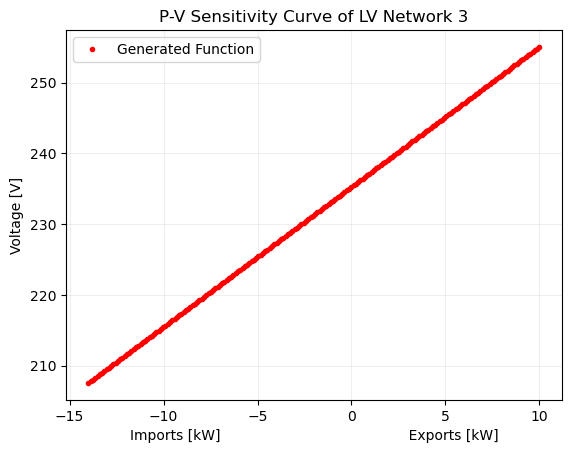

In [5]:
# Select the LV network for which the P-V sensitivity curve should be plotted. Note that not all LV network has a P-V
# sensitivity curve because not all of them have flexible customers
lv_sensit_curve_to_plot = 3

# code for the plot
plt.figure()
p_tx_temp = np.linspace(-14,10,200)
for i in range(len(p_tx_temp)):
    if i == 0:
        plt.plot(p_tx_temp[i], all_p_v_sensit_curve[lv_sensit_curve_to_plot](p_tx_temp[i]), '.', color='red',  label='Generated Function')
    else:
        plt.plot(p_tx_temp[i], all_p_v_sensit_curve[lv_sensit_curve_to_plot](p_tx_temp[i]), '.', color='red')
plt.title('P-V Sensitivity Curve of LV Network '+str(lv_sensit_curve_to_plot))
plt.xlabel('Imports [kW]                                           Exports [kW]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

### 5.5. Create Functions for the Asset Capacity & Critical Voltage OE Algorithms
#### OEs for Exports with Proportional Allocation
<span style="color:red">**<u>Note 1</u>.</span>** To keep consistency to the Ideal OE repository, below we present a code for the Asset Capacity OE exports that has 20% for the OE reduction step as default (instead of the origianl 1% used for the report).

<span style="color:red">**<u>Note 2</u>.</span>** You can update the OE reduction step back to the original 1% (or any other percentage) by changing the parameter "oe_step_size" as explained in the code cell below in the lines 29-34.

In [6]:
def ac_crv_oe_exp_algorithm(
    all_flex_cust_names_per_lv,
    all_flex_cust_der_size,
    all_lv_tx_spare_cap_exp,
    all_lv_hof_spare_cap_exp,
    hv_hof_spare_cap_exp,
    all_p_v_sensit_curves,
    name_all_crit_cust,
):
    """
    Function to calculate the Asset Capacity & Critical Voltage OE proportional allocation for exports in each time step.
    This is used in all time steps of the day.    
    :param all_flex_cust_names_per_lv: name of all flexible customers in the integrated MV-LV networks separated by LV network 
    :param all_flex_cust_der_size: DER size of all flexible customers in the integrated MV-LV network
    :param all_lv_tx_spare_cap_exp: the export spare capacity of all distribution transformers of the integrated MV-LV network 
    :param all_lv_hof_spare_cap_exp: the export spare capacity of all LV head of feeders of the integrated MV-LV network 
    :param hv_hof_spare_cap_exp: the export spare capacity of the MV head of feeder
    :param all_p_v_sensit_curves: P-V sensitivity curves for all LV networks of the integrated MV-LV network
    :param name_all_crit_cust: name of all critical customers (one per LV network) of the integrated MV-LV network
    :return final_alloc_exp_p: the calculated Asset Capacity & Critical Voltage OE export value for proportional allocation
    """
    
    # initialise local variables
    # Each flexible customer starts with an OE with the size of the corresponding DER size
    oe_percent = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        oe_percent[itx] = 1 
        
    ###--IMPORTANT--###    
    # Pre-defined reduction for the OE values (in percentage). If higher precision on the OE value is needed, this step 
    # can be reduced. In the report this value was set to 0.01, meaning 1% reduction. Here it was increased to 20% to 
    # keep consistency with the Ideal OE repository.
    oe_step_size = 0.20 # 20% reduction; if you want to test a different reduction step, choose a number between 0 and 1
    ###-------------###            
        
        
    # initialisation of the operating envelope values 
    alloc_exp_p_temp = [[]] * len(all_flex_cust_names_per_lv)
    for itx in range(len(all_flex_cust_names_per_lv)):
        if any(all_flex_cust_names_per_lv[itx]):
            alloc_exp_p_temp[itx] = np.zeros(len(all_flex_cust_names_per_lv[itx]), float)


    # Check if there is spare capacity on each distribution transformer of the integrated MV-LV network. If positive, 
    # there is spare capacity. If negative or zero, the allocated operating envelope is equal to zero (same value as 
    # initialisation)
    for itx in range(len(all_flex_cust_names_per_lv)): # loop in each LV network of the integrated MV-LV network
        if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
            tx_spare_capacity_temp = copy.deepcopy(all_lv_tx_spare_cap_exp[itx]) # copy the distribution transformer spare capacity to a temporary variable
            while tx_spare_capacity_temp > 0: # check if there is spare capacity
                max_posssible_oe_temp = copy.deepcopy(all_flex_cust_der_size[itx]) # the maximum possible OE value is the DER capacity of each flexible customer
                for ild in range(len(all_flex_cust_names_per_lv[itx])): # iterate through all flexible customers of the LV network to calculate the OE value
            
                    # Proportionally allocate spare capacity of the distribution transformer to each flexible customer of the LV network
                    alloc_exp_p_temp[itx][ild] += tx_spare_capacity_temp * all_flex_cust_der_size[itx][ild] / sum(all_flex_cust_der_size[itx]) 
                
                    # Check if the allocated spare capacity pass the maximum possible OE value and cap it if needed
                    if alloc_exp_p_temp[itx][ild] > all_flex_cust_der_size[itx][ild] or alloc_exp_p_temp[itx][ild] > 10:  
                        alloc_exp_p_temp[itx][ild] = all_flex_cust_der_size[itx][ild] 
                        if alloc_exp_p_temp[itx][ild] > 10:
                            alloc_exp_p_temp[itx][ild] = 10 # 10kVA is the maximum allowed OE value for exports per phase (supersede DER size)
                
                    # Maximum possible OE value for each customer
                    if max_posssible_oe_temp[ild] > 10:
                        max_posssible_oe_temp[ild] = 10
            
                # check if the maximum possible OE value was achieved to all flexible customers
                if (alloc_exp_p_temp[itx] == max_posssible_oe_temp).all():
                    break # the maximum possible OE value was achieved to all flexible customers in this LV network
                else: # there are still some flexible customers below the maximum possible OE value 
                    # check if there is still some spare capacity to be allocated
                    tx_spare_capacity_temp = all_lv_tx_spare_cap_exp[itx] - sum(alloc_exp_p_temp[itx]) 



            # check if LV hof are expected to be within the available spare capacity
            while all_lv_tx_spare_cap_exp[itx] > 0: # check if there are flexible customers in the LV network    
                number_feeders = 0
                for ifd in range(5): # 5 is the maximum number of LV feeders in any LV network in this integrated MV-LV network
                    if all_lv_hof_spare_cap_exp[itx, ifd, 0] != -1: # check if the LV feeder exists in this LV network
                        number_feeders += 1 # if the LV feeder exists, count it
                number_cust_per_feeder = len(all_flex_cust_names_per_lv[itx]) / number_feeders # estimate number of customers per feeder by equally dividing them among feeders
                expected_kva_per_feeder = np.zeros((number_feeders, 3), float)
                flag_lv_hof = np.zeros(number_feeders) # flag to indicate if there are thermal problems in the LV HoF (1 => within thermal limits; 0 => above thermal limits)
                for ifd in range(int(number_feeders)): # loop in all LV feeders of the LV network
                    oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage)
                    agg_kva_lv_feeder = 0
                    # estimate the aggregated kVA of the LV feeder when using the current OE value
                    for ild in range(int(number_cust_per_feeder)):
                        agg_kva_lv_feeder += alloc_exp_p_temp[itx][ifd * int(np.floor(number_cust_per_feeder)) + ild] * oe_percent[itx]
                    # check if all three phases of the LV feeder are being used 
                    if (all_lv_hof_spare_cap_exp[itx, ifd, 0] >= 0 and all_lv_hof_spare_cap_exp[itx, ifd, 1] >= 0 and 
                    all_lv_hof_spare_cap_exp[itx, ifd, 2] >= 0):
                        expected_kva_per_feeder[ifd, 0] = agg_kva_lv_feeder / 3 # divide the estimated aggregated kVA by the three phases
                        expected_kva_per_feeder[ifd, 1] = agg_kva_lv_feeder / 3 # divide the estimated aggregated kVA by the three phases
                        expected_kva_per_feeder[ifd, 2] = agg_kva_lv_feeder / 3 # divide the estimated aggregated kVA by the three phases
                        # check if the estimated power on the LV HoF is within its spare capacity (per phase)
                        if (expected_kva_per_feeder[ifd, 0] <= all_lv_hof_spare_cap_exp[itx, ifd, 0] and 
                            expected_kva_per_feeder[ifd, 1] <= all_lv_hof_spare_cap_exp[itx, ifd, 1] and 
                            expected_kva_per_feeder[ifd, 2] <= all_lv_hof_spare_cap_exp[itx, ifd, 2]):
                            flag_lv_hof[ifd] = 1 # 1 = within the limits
                        else:
                            oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                            if oe_percent[itx] < 0: # check if OEs are below zero
                                oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                                if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                    flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                    # check if only two phases of the LV feeder are being used 
                    elif all_lv_hof_spare_cap_exp[itx, ifd, 0] >= 0 and all_lv_hof_spare_cap_exp[itx, ifd, 1] >= 0:
                        expected_kva_per_feeder[ifd, 0] = agg_kva_lv_feeder / 2 # divide the estimated aggregated kVA by the two phases
                        expected_kva_per_feeder[ifd, 1] = agg_kva_lv_feeder / 2 # divide the estimated aggregated kVA by the two phases
                        # check if the estimated power on the LV HoF is within its spare capacity (per phase)
                        if (expected_kva_per_feeder[ifd, 0] <= all_lv_hof_spare_cap_exp[itx, ifd, 0] and 
                            expected_kva_per_feeder[ifd, 1] <= all_lv_hof_spare_cap_exp[itx, ifd, 1]):
                            flag_lv_hof[ifd] = 1 # 1 = within the limits
                        else:
                            oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                            if oe_percent[itx] < 0: # check if OEs are below zero
                                oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                                if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                    flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                    # check if only one phase of the LV feeder is being used
                    elif all_lv_hof_spare_cap_exp[itx, ifd, 0] >= 0:
                        expected_kva_per_feeder[ifd, 0] = agg_kva_lv_feeder # allocate the estimated aggregated kVA to the phase
                        # check if the estimated power on the LV HoF is within its spare capacity (per phase)
                        if expected_kva_per_feeder[ifd, 0] <= all_lv_hof_spare_cap_exp[itx, ifd, 0]:
                            flag_lv_hof[ifd] = 1 # 1 = within the limits
                        else:
                            oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                            if oe_percent[itx] < 0: # check if OEs are below zero
                                oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                                if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                    flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                    else:
                        oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OEs are below zero
                            oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                # check if there is any thermal problem expected in the LV HoF (1 => within thermal limits; 0 => above thermal limits)
                if (flag_lv_hof == 1).all():
                    break # no thermal problems



    # check if the MV HoF is expected to be within the available spare capacity
    flag_hv_hof = 0 # flag to indicate if there is any thermal problem expected in the MV HoF (1 => within thermal limits; 0 => above thermal limits)
    while flag_hv_hof == 0:
        # Estimate the aggregated kVA in the MV HoF
        agg_kva_hv_feeder = np.zeros(len(all_flex_cust_names_per_lv), float)
        oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage)
        for itx in range(len(all_flex_cust_names_per_lv)): # loop to iterate through each LV network
            if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                for ild in range(len(all_flex_cust_names_per_lv[itx])): # loop to iterate through each flexibel customer in the LV network
                    agg_kva_hv_feeder[itx] += alloc_exp_p_temp[itx][ild] * oe_percent[itx] # estimate the aggregated kVA in the MV HoF
        # Check if the estimated aggregated kVA in the MV HoF is above spare capacity (per phase)
        if ((sum(agg_kva_hv_feeder) / 3) > hv_hof_spare_cap_exp[0] or 
            (sum(agg_kva_hv_feeder) / 3) > hv_hof_spare_cap_exp[1] or 
            (sum(agg_kva_hv_feeder) / 3) > hv_hof_spare_cap_exp[2]):
            for itx in range(len(all_flex_cust_names_per_lv)):
                if any(all_flex_cust_names_per_lv[itx]):
                    oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                    if oe_percent[itx] < 0: # check if OEs are below zero
                        oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                flag_hv_hof = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
        else:
            flag_hv_hof = 1 # the estimated aggregated kVA in the MV HoF is within the spare capacity
   
    
    
    # Estimate the voltage at each critical customer (using the P-V sensitivity curve) and check if they is above limits
    for itx in range(len(all_flex_cust_names_per_lv)): # loop to iterate through each LV network
        if any(all_flex_cust_names_per_lv[itx]): # check if there are flexible customers in the LV network
            index_crit_cust = all_flex_cust_names_per_lv[itx].index(name_all_crit_cust[itx]) # collect the index of the critical customer of the LV network
            while all_lv_tx_spare_cap_exp[itx] > 0:
                # Expected net active power at the critical customer (based on the allocated OE value)
                expected_pnet_crit_cust = alloc_exp_p_temp[itx][index_crit_cust] * oe_percent[itx]
                    
                # Use the P-V sensitivity curve to estimate the voltage at the critical customer for the expected active power export
                expected_v_crit_cust = all_p_v_sensit_curves[itx](expected_pnet_crit_cust)
            
                # Check if the estimated voltage at the critical customer is above 253V  
                if expected_v_crit_cust > 253:
                    oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                    if oe_percent[itx] < 0: # check if OEs are below zero
                        oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                        break # Voltage problems are still expected even after OE value is equal to zero. OE calculation finished
                else:
                    break # No voltage problems are expected. OE calculation finished.

    

    # Find final allocated OEs in kW
    final_alloc_exp_p = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        if any(all_flex_cust_der_size[itx]):
            for ild in range(len(all_flex_cust_der_size[itx])):
                if ild == 0:
                    final_alloc_exp_p[itx] = np.zeros(len(all_flex_cust_der_size[itx]), float)
                final_alloc_exp_p[itx][ild] = alloc_exp_p_temp[itx][ild] * oe_percent[itx]
    
    return final_alloc_exp_p # return the calculated OE value for the export for the considered time step

#### OEs for Imports with Proportional Allocation
<span style="color:red">**<u>Note 1</u>.</span>** To keep consistency to the Ideal OE repository, below we present a code for the Asset Capacity OE exports that has 20% for the OE reduction step as default (instead of the origianl 1% used for the report).

<span style="color:red">**<u>Note 2</u>.</span>** You can update the OE reduction step back to the original 1% (or any other percentage) by changing the parameter "oe_step_size" as explained in the code cell below in the lines 29-34.

In [7]:
def ac_crv_oe_imp_algorithm(
    all_flex_cust_names_per_lv,
    all_flex_cust_der_size,
    all_lv_tx_spare_cap_imp,
    all_lv_hof_spare_cap_imp,
    hv_hof_spare_cap_imp,
    all_p_v_sensit_curves,
    name_all_crit_cust,
):
    """
    Function to calculate the Asset Capacity & Critical Voltage OE proportional allocation for imports in each time step.
    This is used in all time steps.    
    :param all_flex_cust_names_per_lv: name of all flexible customers in the integrated MV-LV networks separated by LV network 
    :param all_flex_cust_der_size: DER size of all flexible customers in the integrated MV-LV network
    :param all_lv_tx_spare_cap_imp: the import spare capacity of all distribution transformers of the integrated MV-LV network 
    :param all_lv_hof_spare_cap_imp: the import spare capacity of all LV head of feeders of the integrated MV-LV network 
    :param hv_hof_spare_cap_imp: the import spare capacity of the MV head of feeder
    :param all_p_v_sensit_curves: P-V sensitivity curves for all LV networks of the integrated MV-LV network
    :param name_all_crit_cust: name of all critical customers (one per LV network) of the integrated MV-LV network
    :return final_alloc_imp_p: the calculated Asset Capacity & Critical Voltage OE import value for proportional allocation
    """
    
    # initialise local variables
    # Each flexible customer starts with an OE with the size of the corresponding DER size
    oe_percent = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        oe_percent[itx] = 1 
        
    ###--IMPORTANT--###    
    # Pre-defined reduction for the OE values (in percentage). If higher precision on the OE value is needed, this step 
    # can be reduced. In the report this value was set to 0.01, meaning 1% reduction. Here it was increased to 20% to 
    # keep consistency with the Ideal OE repository.
    oe_step_size = 0.20 # 20% reduction; if you want to test a different reduction step, choose a number between 0 and 1
    ###-------------###            
        
        
    # initialisation of the operating envelope values 
    alloc_imp_p_temp = [[]] * len(all_flex_cust_names_per_lv)
    max_possible_oe_imp_temp = copy.deepcopy(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_names_per_lv)):
        if any(all_flex_cust_names_per_lv[itx]):
            alloc_imp_p_temp[itx] = np.zeros(len(all_flex_cust_names_per_lv[itx]), float)
            for ild in range(len(all_flex_cust_names_per_lv[itx])):
                max_possible_oe_imp_temp[itx][ild] = 14 # 14kVA is the maximum per phase allowed OE value for imports


    # Check if there is spare capacity on each distribution transformer of the integrated MV-LV network. If positive, 
    # there is spare capacity. If negative or zero, the allocated operating envelope is equal to zero (same value as 
    # initialisation)
    for itx in range(len(all_flex_cust_names_per_lv)): # loop in each LV network of the integrated MV-LV network
        if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
            tx_spare_capacity_temp = copy.deepcopy(all_lv_tx_spare_cap_imp[itx]) # copy the distribution transformer spare capacity to a temporary variable
            while tx_spare_capacity_temp > 0: # check if there is spare capacity
                for ild in range(len(all_flex_cust_names_per_lv[itx])): # iterate through all flexible customers of the LV network to calculate the OE value
            
                    # Proportionally allocate spare capacity of the distribution transformer to each flexible customer of the LV network
                    alloc_imp_p_temp[itx][ild] += tx_spare_capacity_temp * max_possible_oe_imp_temp[itx][ild] / sum(max_possible_oe_imp_temp[itx]) 
                
                    # Check if the allocated spare capacity pass the maximum possible OE value and cap it if needed
                    if alloc_imp_p_temp[itx][ild] > max_possible_oe_imp_temp[itx][ild]:  
                        alloc_imp_p_temp[itx][ild] = max_possible_oe_imp_temp[itx][ild] 
                
                # check if the maximum possible OE value was achieved to all flexible customers
                if (alloc_imp_p_temp[itx] == max_possible_oe_imp_temp[itx]).all():
                    break # the maximum possible OE value was achieved to all flexible customers in this LV network
                else: # there are still some flexible customers below the maximum possible OE value 
                    # check if there is still some spare capacity to be allocated
                    tx_spare_capacity_temp = all_lv_tx_spare_cap_imp[itx] - sum(alloc_imp_p_temp[itx]) 



            # check if LV hof are expected to be within the available spare capacity
            while all_lv_tx_spare_cap_imp[itx] > 0: # check if there are flexible customers in the LV network    
                number_feeders = 0
                for ifd in range(5): # 5 is the maximum number of LV feeders in any LV network in this integrated MV-LV network
                    if all_lv_hof_spare_cap_imp[itx, ifd, 0] != -1: # check if the LV feeder exists in this LV network
                        number_feeders += 1 # if the LV feeder exists, count it
                number_cust_per_feeder = len(all_flex_cust_names_per_lv[itx]) / number_feeders # estimate number of customers per feeder by equally dividing them among feeders
                expected_kva_per_feeder = np.zeros((number_feeders, 3), float)
                flag_lv_hof = np.zeros(number_feeders) # flag to indicate if there are thermal problems in the LV HoF (1 => within thermal limits; 0 => above thermal limits)
                for ifd in range(int(number_feeders)): # loop in all LV feeders of the LV network
                    oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage)
                    agg_kva_lv_feeder = 0
                    # estimate the aggregated kVA of the LV feeder when using the current OE value
                    for ild in range(int(number_cust_per_feeder)):
                        agg_kva_lv_feeder += alloc_imp_p_temp[itx][ifd * int(np.floor(number_cust_per_feeder)) + ild] * oe_percent[itx]
                    # check if all three phases of the LV feeder are being used 
                    if (all_lv_hof_spare_cap_imp[itx, ifd, 0] >= 0 and all_lv_hof_spare_cap_imp[itx, ifd, 1] >= 0 and 
                    all_lv_hof_spare_cap_imp[itx, ifd, 2] >= 0):
                        expected_kva_per_feeder[ifd, 0] = agg_kva_lv_feeder / 3 # divide the estimated aggregated kVA by the three phases
                        expected_kva_per_feeder[ifd, 1] = agg_kva_lv_feeder / 3 # divide the estimated aggregated kVA by the three phases
                        expected_kva_per_feeder[ifd, 2] = agg_kva_lv_feeder / 3 # divide the estimated aggregated kVA by the three phases
                        # check if the estimated power on the LV HoF is within its spare capacity (per phase)
                        if (expected_kva_per_feeder[ifd, 0] <= all_lv_hof_spare_cap_imp[itx, ifd, 0] and 
                            expected_kva_per_feeder[ifd, 1] <= all_lv_hof_spare_cap_imp[itx, ifd, 1] and 
                            expected_kva_per_feeder[ifd, 2] <= all_lv_hof_spare_cap_imp[itx, ifd, 2]):
                            flag_lv_hof[ifd] = 1 # 1 = within the limits
                        else:
                            oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                            if oe_percent[itx] < 0: # check if OEs are below zero
                                oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                                if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                    flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                    # check if only two phases of the LV feeder are being used 
                    elif all_lv_hof_spare_cap_imp[itx, ifd, 0] >= 0 and all_lv_hof_spare_cap_imp[itx, ifd, 1] >= 0:
                        expected_kva_per_feeder[ifd, 0] = agg_kva_lv_feeder / 2 # divide the estimated aggregated kVA by the two phases
                        expected_kva_per_feeder[ifd, 1] = agg_kva_lv_feeder / 2 # divide the estimated aggregated kVA by the two phases
                        # check if the estimated power on the LV HoF is within its spare capacity (per phase)
                        if (expected_kva_per_feeder[ifd, 0] <= all_lv_hof_spare_cap_imp[itx, ifd, 0] and 
                            expected_kva_per_feeder[ifd, 1] <= all_lv_hof_spare_cap_imp[itx, ifd, 1]):
                            flag_lv_hof[ifd] = 1 # 1 = within the limits
                        else:
                            oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                            if oe_percent[itx] < 0: # check if OEs are below zero
                                oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                                if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                    flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                    # check if only one phase of the LV feeder is being used
                    elif all_lv_hof_spare_cap_imp[itx, ifd, 0] >= 0:
                        expected_kva_per_feeder[ifd, 0] = agg_kva_lv_feeder # allocate the estimated aggregated kVA to the phase
                        # check if the estimated power on the LV HoF is within its spare capacity (per phase)
                        if expected_kva_per_feeder[ifd, 0] <= all_lv_hof_spare_cap_imp[itx, ifd, 0]:
                            flag_lv_hof[ifd] = 1 # 1 = within the limits
                        else:
                            oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                            if oe_percent[itx] < 0: # check if OEs are below zero
                                oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                                if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                    flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                    else:
                        oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OEs are below zero
                            oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_lv_hof[ifd] = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                # check if there is any thermal problem expected in the LV HoF (1 => within thermal limits; 0 => above thermal limits)
                if (flag_lv_hof == 1).all():
                    break # no thermal problems



    # check if the MV HoF is expected to be within the available spare capacity
    flag_hv_hof = 0 # flag to indicate if there is any thermal problem expected in the MV HoF (1 => within thermal limits; 0 => above thermal limits)
    while flag_hv_hof == 0:
        # Estimate the aggregated kVA in the MV HoF
        agg_kva_hv_feeder = np.zeros(len(all_flex_cust_names_per_lv), float)
        oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage)
        for itx in range(len(all_flex_cust_names_per_lv)): # loop to iterate through each LV network
            if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                for ild in range(len(all_flex_cust_names_per_lv[itx])): # loop to iterate through each flexibel customer in the LV network
                    agg_kva_hv_feeder[itx] += alloc_imp_p_temp[itx][ild] * oe_percent[itx] # estimate the aggregated kVA in the MV HoF
        # Check if the estimated aggregated kVA in the MV HoF is above spare capacity (per phase)
        if ((sum(agg_kva_hv_feeder) / 3) > hv_hof_spare_cap_imp[0] or 
            (sum(agg_kva_hv_feeder) / 3) > hv_hof_spare_cap_imp[1] or 
            (sum(agg_kva_hv_feeder) / 3) > hv_hof_spare_cap_imp[2]):
            for itx in range(len(all_flex_cust_names_per_lv)):
                if any(all_flex_cust_names_per_lv[itx]):
                    oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                    if oe_percent[itx] < 0: # check if OEs are below zero
                        oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                flag_hv_hof = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
        else:
            flag_hv_hof = 1 # the estimated aggregated kVA in the MV HoF is within the spare capacity
   
    
    
    # Estimate the voltage at each critical customer (using the P-V sensitivity curve) and check if they is above limits
    for itx in range(len(all_flex_cust_names_per_lv)): # loop to iterate through each LV network
        if any(all_flex_cust_names_per_lv[itx]): # check if there are flexible customers in the LV network
            index_crit_cust = all_flex_cust_names_per_lv[itx].index(name_all_crit_cust[itx]) # collect the index of the critical customer of the LV network
            while all_lv_tx_spare_cap_imp[itx] > 0:
                # Expected net active power at the critical customer (based on the allocated OE value)
                expected_pnet_crit_cust = alloc_imp_p_temp[itx][index_crit_cust] * oe_percent[itx]
                    
                # Use the P-V sensitivity curve to estimate the voltage at the critical customer for the expected active power export
                expected_v_crit_cust = all_p_v_sensit_curves[itx](expected_pnet_crit_cust)
            
                # Check if the estimated voltage at the critical customer is above 253V  
                if expected_v_crit_cust > 253:
                    oe_percent[itx] -= oe_step_size # if above any limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                    if oe_percent[itx] < 0: # check if OEs are below zero
                        oe_percent[itx] = 0 # OEs cannot be below zero, so make it equal to zero
                        break # Voltage problems are still expected even after OE value is equal to zero. OE calculation finished
                else:
                    break # No voltage problems are expected. OE calculation finished.

    

    # Find final allocated OEs in kW
    final_alloc_imp_p = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        if any(all_flex_cust_der_size[itx]):
            for ild in range(len(all_flex_cust_der_size[itx])):
                if ild == 0:
                    final_alloc_imp_p[itx] = np.zeros(len(all_flex_cust_der_size[itx]), float)
                final_alloc_imp_p[itx][ild] = alloc_imp_p_temp[itx][ild] * oe_percent[itx]
    
    return final_alloc_imp_p # return the calculated OE value for the import for the considered time step

### 5.6. Calculate the Asset Capacity & Critical Voltage OE with the Integrated MV-LV Approach
<span style="color:red">**<u>Note 1</u>.</span>** To keep consistency to the Ideal OE repository, below we present a code for the Asset Capacity & Critical Voltage OE exports and imports that has its default to simulate only two hours, not the whole three days.

<span style="color:red">**<u>Note 2</u>.</span>** You can activate the full three days simulation by changing the parameter "full_simulation" as explained in the code cell below in the lines 1-4. 

In [8]:
###--IMPORTANT--###
# Update this parameter to 1, in case you want to simulate the full three days (it will take around 9 hours)
full_simulation = 0 # 0=> simplified simulation (simulates 2h of the first day); 1=> full three days simulation (simulates 72h)
###-------------###

# Initialise arrays to save the OE values from all customers in the integrated MV-LV distribution network for each time step
save_ac_crv_oe_prop_exp_values = [[]] * num_time_steps*num_days # for exports
save_ac_crv_oe_prop_imp_values = [[]] * num_time_steps*num_days # for imports



 
if full_simulation == 0: # simplified simulation (simulates 2h of the first day)
    # Calculate the OE values for each time step of the simulation in a for loop
    for itime in range(24):
    
        if itime == 0:
            print('You are simulating 2h starting from 12PM of the first day.\nThis should take less than a minute to finish, but simulation time vary for different computers.')        

        save_ac_crv_oe_prop_exp_values[itime] = []
        save_ac_crv_oe_prop_imp_values[itime] = []    
    
        # prepare LV HoF data for the OE calculation function
        all_lv_hof_spare_cap_exp = np.ones((num_distr_tx, 5, 3), float) * -1 # 5 => maximum number of feeders in a LV network; 3 => number or phases
        all_lv_hof_spare_cap_imp = np.ones((num_distr_tx, 5, 3), float) * -1 # 5 => maximum number of feeders in a LV network; 3 => number or phases
        for itx in range(num_distr_tx): # loop to iterate through all LV networks in the MV-LV network
            if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer on the LV network
                for ifd in range(lv_total_feeders[itx]): # loop to iterate through all feeders on the LV network
                    # check if all three phases of the LV feeder are being used
                    if (lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'] and 
                        lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'] and 
                        lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseC']):
                        # separate the spare capacity for the current time step
                        all_lv_hof_spare_cap_exp[itx, ifd, 0] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][144 + itime]
                        all_lv_hof_spare_cap_exp[itx, ifd, 1] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][144 + itime]
                        all_lv_hof_spare_cap_exp[itx, ifd, 2] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseC'][144 + itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 0] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][144 + itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 1] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][144 + itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 2] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseC'][144 + itime]
                    # check if two phases of the LV feeder are being used
                    elif (lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'] and 
                          lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB']):
                        # separate the spare capacity for the current time step
                        all_lv_hof_spare_cap_exp[itx, ifd, 0] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][144 + itime]
                        all_lv_hof_spare_cap_exp[itx, ifd, 1] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][144 + itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 0] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][144 + itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 1] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][144 + itime]                
                    # check if only one phase of the LV feeder is being used
                    elif lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA']:
                        # separate the spare capacity for the current time step
                        all_lv_hof_spare_cap_exp[itx, ifd, 0] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][144 + itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 0] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][144 + itime]
    
        # call the Asset Capacity & Critical Voltage OE functions to calculate the OE value to each time step
        ac_crv_oe_prop_exp_values = ac_crv_oe_exp_algorithm(all_flex_cust_names_per_lv, all_flex_cust_der_size, lvtx_spare_capacity_exp[:, 144 + itime], all_lv_hof_spare_cap_exp, hv_hof_spare_cap_exp[:, 144 +  itime], all_p_v_sensit_curve, name_crit_cust_per_lv) # export
        ac_crv_oe_prop_imp_values = ac_crv_oe_imp_algorithm(all_flex_cust_names_per_lv, all_flex_cust_der_size, lvtx_spare_capacity_imp[:, 144 + itime], all_lv_hof_spare_cap_imp, hv_hof_spare_cap_imp[:, 144 +  itime], all_p_v_sensit_curve, name_crit_cust_per_lv) # export

        save_ac_crv_oe_prop_exp_values[itime].append(ac_crv_oe_prop_exp_values)
        save_ac_crv_oe_prop_imp_values[itime].append(ac_crv_oe_prop_imp_values)

    print('Simulation finished. The OEs were saved and can be visualised and assessed in the code cells below.')    
    

    
    
if full_simulation == 1: # full three days simulation (simulates 72h)
    # Calculate the OE values for each time step of the simulation in a for loop
    for itime in range(num_time_steps*num_days):
    
        if itime == 0:
            print('You are simulating three complete days (72h).\nThis should take less than a minute to finish, but simulation time vary for different computers.')

        save_ac_crv_oe_prop_exp_values[itime] = []
        save_ac_crv_oe_prop_imp_values[itime] = []    
    
        # prepare LV HoF data for the OE calculation function
        all_lv_hof_spare_cap_exp = np.ones((num_distr_tx, 5, 3), float) * -1 # 5 => maximum number of feeders in a LV network; 3 => number or phases
        all_lv_hof_spare_cap_imp = np.ones((num_distr_tx, 5, 3), float) * -1 # 5 => maximum number of feeders in a LV network; 3 => number or phases
        for itx in range(num_distr_tx): # loop to iterate through all LV networks in the MV-LV network
            if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer on the LV network
                for ifd in range(lv_total_feeders[itx]): # loop to iterate through all feeders on the LV network
                    # check if all three phases of the LV feeder are being used
                    if (lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'] and 
                        lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'] and 
                        lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseC']):
                        # separate the spare capacity for the current time step
                        all_lv_hof_spare_cap_exp[itx, ifd, 0] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][itime]
                        all_lv_hof_spare_cap_exp[itx, ifd, 1] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][itime]
                        all_lv_hof_spare_cap_exp[itx, ifd, 2] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseC'][itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 0] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 1] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 2] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseC'][itime]
                    # check if two phases of the LV feeder are being used
                    elif (lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'] and 
                          lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB']):
                        # separate the spare capacity for the current time step
                        all_lv_hof_spare_cap_exp[itx, ifd, 0] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][itime]
                        all_lv_hof_spare_cap_exp[itx, ifd, 1] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 0] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 1] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseB'][itime]                
                    # check if only one phase of the LV feeder is being used
                    elif lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA']:
                        # separate the spare capacity for the current time step
                        all_lv_hof_spare_cap_exp[itx, ifd, 0] = lv_hof_spare_capacity_exp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][itime]
                        all_lv_hof_spare_cap_imp[itx, ifd, 0] = lv_hof_spare_capacity_imp['lv'+str(itx)]['feeder'+str(ifd)]['PhaseA'][itime]
    
        # call the Asset Capacity & Critical Voltage OE functions to calculate the OE value to each time step
        ac_crv_oe_prop_exp_values = ac_crv_oe_exp_algorithm(all_flex_cust_names_per_lv, all_flex_cust_der_size, lvtx_spare_capacity_exp[:, itime], all_lv_hof_spare_cap_exp, hv_hof_spare_cap_exp[:, itime], all_p_v_sensit_curve, name_crit_cust_per_lv) # export
        ac_crv_oe_prop_imp_values = ac_crv_oe_imp_algorithm(all_flex_cust_names_per_lv, all_flex_cust_der_size, lvtx_spare_capacity_imp[:, itime], all_lv_hof_spare_cap_imp, hv_hof_spare_cap_imp[:, itime], all_p_v_sensit_curve, name_crit_cust_per_lv) # export

        save_ac_crv_oe_prop_exp_values[itime].append(ac_crv_oe_prop_exp_values)
        save_ac_crv_oe_prop_imp_values[itime].append(ac_crv_oe_prop_imp_values)

    print('Simulation finished. The OEs were saved and can be visualised and assessed in the code cells below.')

You are simulating 2h starting from 12PM of the first day.
This should take less than a minute to finish, but simulation time vary for different computers.
Simulation finished. The OEs were saved and can be visualised and assessed in the code cells below.


#### Visualisation of the Calculated Asset Capacity & Critical Voltage OE Export

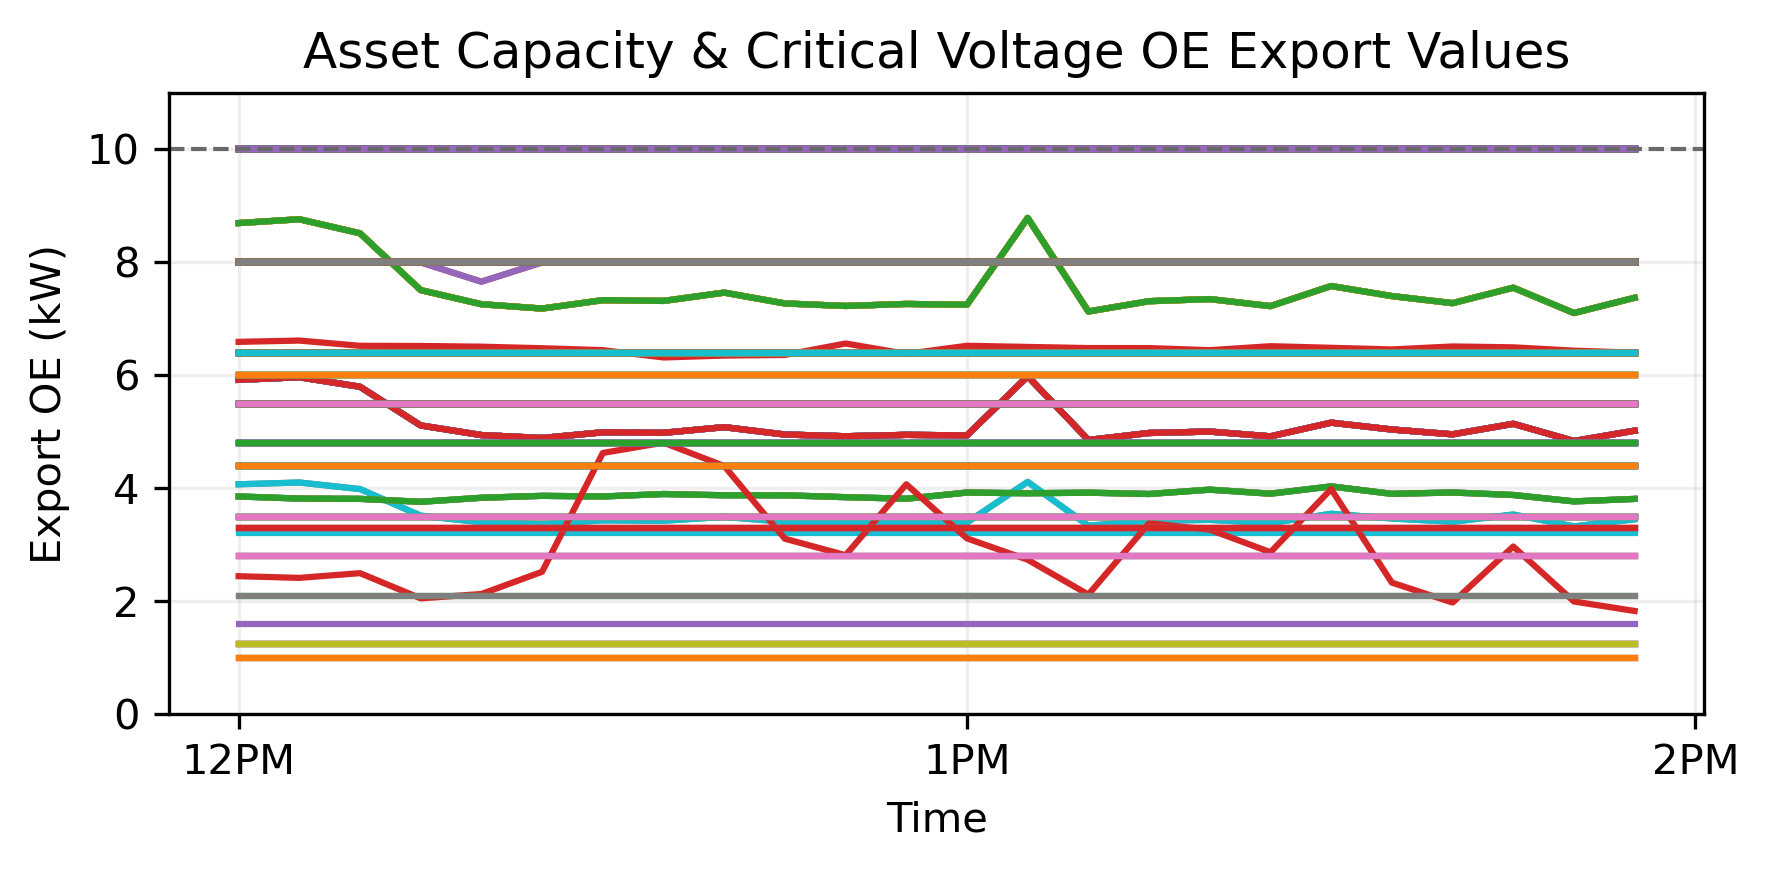

Comments about the figure above:
- Each solid line corresponds to the OE export value of a flexible customer for 2h of the first day.
- Note that there are many lines on top of each other, that is why you see less number of lines than you would expect.
- For the OE export, each flexible customer receives a different OE values that is proportional to its DER size. 


In [9]:
if full_simulation == 0: # simplified simulation (simulates 2h of the first day)
    # plot the calculated operating envelopes for exports
    x = range(24)
    y1 = [[]] * num_distr_tx
    for itx in range(num_distr_tx):
        if len(save_ac_crv_oe_prop_exp_values[0][0][itx]) > 0: 
            for ild in range(len(save_ac_crv_oe_prop_exp_values[0][0][itx])):
                if ild == 0:
                    y1[itx] = [[]] * len(save_ac_crv_oe_prop_exp_values[0][0][itx])
                for itime in range(24):
                    if itime == 0:
                        y1[itx][ild] = []
                    y1[itx][ild].append(save_ac_crv_oe_prop_exp_values[itime][0][itx][ild])

    plt.figure(figsize=(6,3), dpi=300)
    ax = plt.axes()
    plt.title("Asset Capacity & Critical Voltage OE Export Values")
    plt.ylabel("Export OE (kW)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        for ild in range(len(y1[itx])):
            plt.plot(x, y1[itx][ild], alpha=1)
    plt.axhline(y = 10, color = 'dimgrey', linestyle = 'dashed', linewidth=1)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.grid(alpha=0.2)
    plt.ylim([0,11])
    plt.tight_layout()
    plt.show()

    print('Comments about the figure above:')
    print('- Each solid line corresponds to the OE export value of a flexible customer for 2h of the first day.')
    print('- Note that there are many lines on top of each other, that is why you see less number of lines than you would expect.')
    print('- For the OE export, each flexible customer receives a different OE values that is proportional to its DER size. ')
    

    
    
if full_simulation == 1: # full three days simulation (simulates 72h)
    # plot the calculated operating envelopes for exports
    x = range(num_time_steps*num_days)
    y1 = [[]] * num_distr_tx
    for itx in range(num_distr_tx):
        if len(save_ac_crv_oe_prop_exp_values[0][0][itx]) > 0: 
            for ild in range(len(save_ac_crv_oe_prop_exp_values[0][0][itx])):
                if ild == 0:
                    y1[itx] = [[]] * len(save_ac_crv_oe_prop_exp_values[0][0][itx])
                for itime in range(num_time_steps*num_days):
                    if itime == 0:
                        y1[itx][ild] = []
                    y1[itx][ild].append(save_ac_crv_oe_prop_exp_values[itime][0][itx][ild])

    plt.figure(figsize=(6,3), dpi=300)
    ax = plt.axes()
    plt.title("Asset Capacity & Critical Voltage OE Export Values")
    plt.ylabel("Export OE (kW)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        for ild in range(len(y1[itx])):
            plt.plot(x, y1[itx][ild], alpha=1)
    plt.axhline(y = 10, color = 'dimgrey', linestyle = 'dashed', linewidth=1)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.grid(alpha=0.2)
    plt.ylim([0,11])
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above:')
    print('- Each solid line corresponds to the OE export value of a flexible customer for the three simulated days (summer). ')
    print('- For the OE export, each flexible customer receives a different OE values that is proportional to its DER size. ')
    print('- Note that there are many lines on top of each other, that is why you see less number of lines than you would expect.')
    print('- The Asset Capacity & Critical Voltage OE creates straight lines when voltage constraints are achieved.')
    print('- The Asset Capacity & Critical Voltage OE can create varying values when thermal constraints are achieved.')
    print('- The OE exports is lower during the day (~12h, ~36h, ~60h), when there is already PV generation on fixed customers, forcing the OE to be reduced for flexible customers.')


#### Visualisation of the Calculated Asset Capacity OE Import

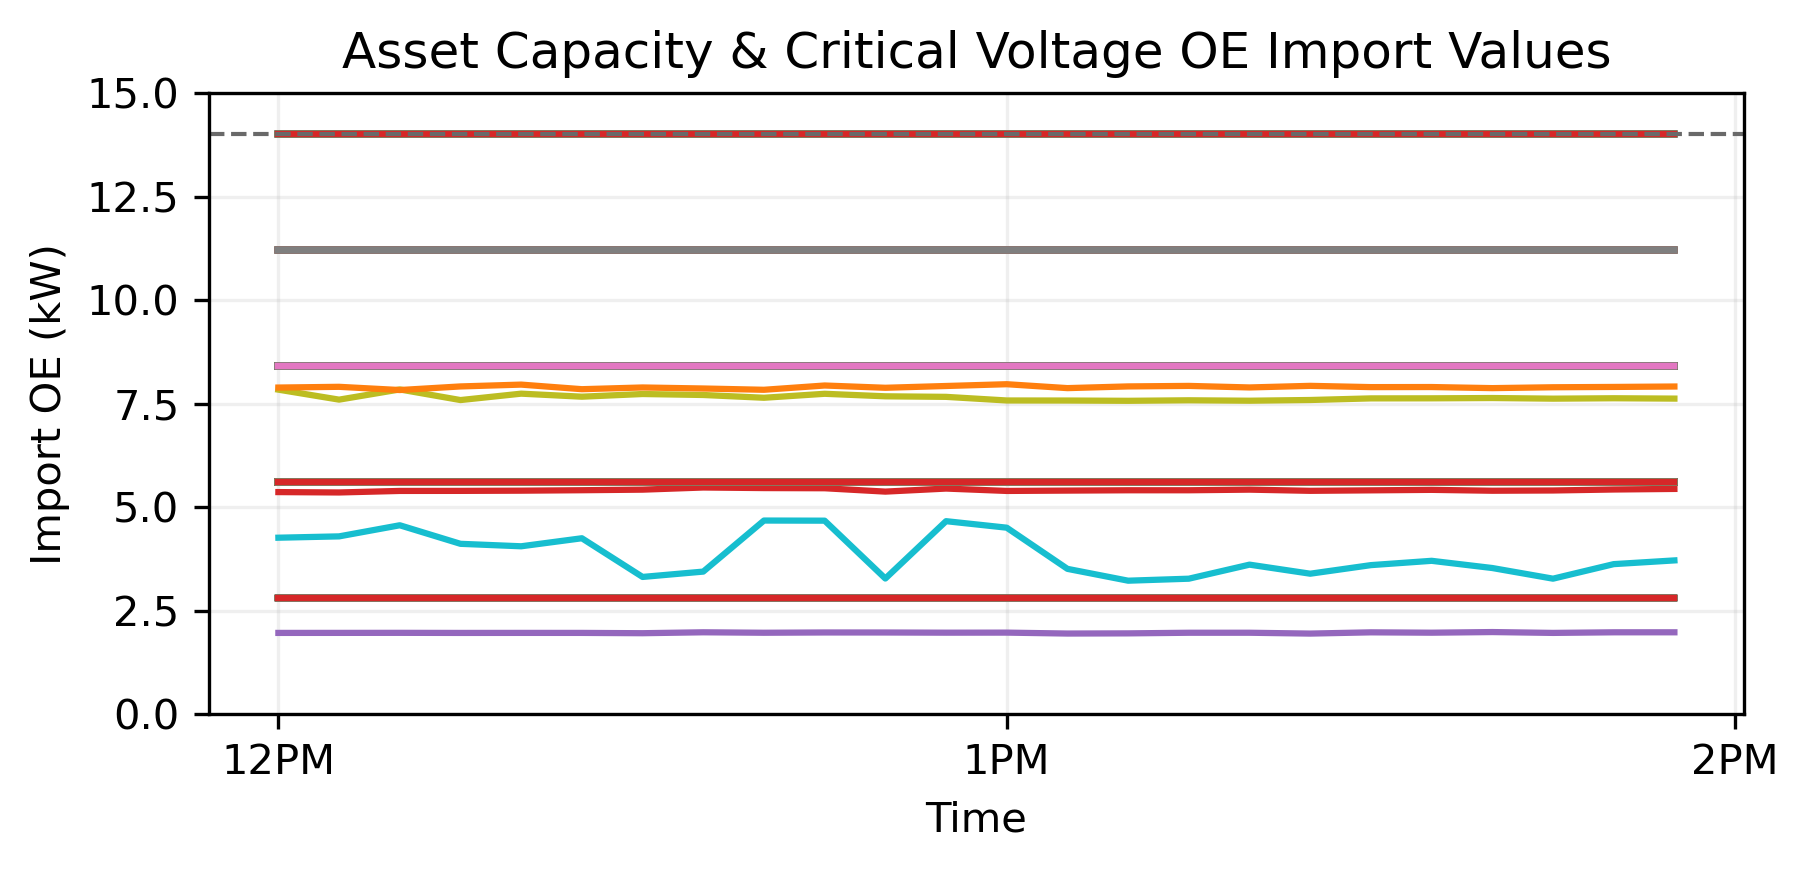

Comments about the figure above:
- Each solid line corresponds to the OE import value of a customer for 2h of the first day.
- Note that there are many lines on top of each other, that is why you see less number of lines than you would expect.
- For the OE import, all customers are assumed to have the same maximum possible OE value which corresponds to the house fuse (14kW).
- Some flexible customers are constrained below the 14kW due to thermal or voltage limits being achieved.


In [10]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # plot the calculated operating envelopes for imports
    x = range(24)
    y1 = [[]] * num_distr_tx
    for itx in range(num_distr_tx):
        if len(save_ac_crv_oe_prop_imp_values[0][0][itx]) > 0: 
            for ild in range(len(save_ac_crv_oe_prop_imp_values[0][0][itx])):
                if ild == 0:
                    y1[itx] = [[]] * len(save_ac_crv_oe_prop_imp_values[0][0][itx])
                for itime in range(24):
                    if itime == 0:
                        y1[itx][ild] = []
                    y1[itx][ild].append(save_ac_crv_oe_prop_imp_values[itime][0][itx][ild])

    plt.figure(figsize=(6,3), dpi=300)
    ax = plt.axes()
    plt.title("Asset Capacity & Critical Voltage OE Import Values")
    plt.ylabel("Import OE (kW)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        for ild in range(len(y1[itx])):
            plt.plot(x, y1[itx][ild], alpha=1)
    plt.axhline(y = 14, color = 'dimgrey', linestyle = 'dashed', linewidth=1)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.grid(alpha=0.2)
    plt.ylim([0,15])
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above:')
    print('- Each solid line corresponds to the OE import value of a customer for 2h of the first day.')
    print('- Note that there are many lines on top of each other, that is why you see less number of lines than you would expect.')
    print('- For the OE import, all customers are assumed to have the same maximum possible OE value which corresponds to the house fuse (14kW).')
    print('- Some flexible customers are constrained below the 14kW due to thermal or voltage limits being achieved.')

    
    

if full_simulation == 1: # full three days simulation (simulates 72h)
    # plot the calculated operating envelopes for imports
    x = range(num_time_steps*num_days)
    y1 = [[]] * num_distr_tx
    for itx in range(num_distr_tx):
        if len(save_ac_crv_oe_prop_imp_values[0][0][itx]) > 0: 
            for ild in range(len(save_ac_crv_oe_prop_imp_values[0][0][itx])):
                if ild == 0:
                    y1[itx] = [[]] * len(save_ac_crv_oe_prop_imp_values[0][0][itx])
                for itime in range(num_time_steps*num_days):
                    if itime == 0:
                        y1[itx][ild] = []
                    y1[itx][ild].append(save_ac_crv_oe_prop_imp_values[itime][0][itx][ild])

    plt.figure(figsize=(6,3), dpi=300)
    ax = plt.axes()
    plt.title("Asset Capacity & Critical Voltage OE Import Values")
    plt.ylabel("Import OE (kW)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        for ild in range(len(y1[itx])):
            plt.plot(x, y1[itx][ild], alpha=1)
    plt.axhline(y = 14, color = 'dimgrey', linestyle = 'dashed', linewidth=1)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.grid(alpha=0.2)
    plt.ylim([0,15])
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above:')
    print('- Each solid line corresponds to the OE import value of a flexible customer for the three simulated days (summer).')
    print('- Note that there are many lines on top of each other, that is why you see less number of lines than you would expect.')
    print('- For the OE import, all flexible customers are assumed to have the same maximum possible OE value which corresponds to the house fuse (14kW).')
    print('- The Asset Capacity & Critical Voltage OE creates straight lines (which can present some small oscillation) when voltage constraints are achieved.')
    print('- The Asset Capacity & Critical Voltage OE can create varying values when thermal constraints are achieved.')

### 5.7. Perfomance Check of the Calculated Asset Capacity & Critical Voltage OE
The calculated OE is implemented in OpenDSS (proxy of real network) to check how it would perform in the real network. Then, a technical assessment of the simulation results is carried out.

<span style="color:red">**<u>Note</u>.</span>** All flexible customers are assumed to be using the full available OE value calculated for them. So, it is the worst possible case.
#### Implementation of the Calculated Asset Capacity & Critical Voltage OE Export

In [11]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Load the integrated MV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
    dss_text.Command = 'Clear'
    dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
    dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
    dss_text.Command = 'calcv'
    dss_text.Command = 'Set ControlMode=static'
    dss_text.Command = 'Reset'                                                     
    dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

    # Extract names of all lines from OpenDSS
    line_names = dss_circuit.Lines.AllNames

    # Extract names of all loads from the OpenDSS
    load_names = dss_circuit.Loads.AllNames

    # Extract names of all distribution transformers from the OpenDSS
    transformer_names = dss_circuit.Transformers.AllNames

    # initialise arrays to save simulation results for each time step
    save_lvtx_util = np.zeros((num_distr_tx, num_time_steps*num_days), float) # save utilisation of all distribution transformers in the integrated MV-LV network
    save_lines_util = np.zeros((len(line_names), 3, num_time_steps*num_days), float) # save utilisation of all lines in the integrated MV-LV network
    save_all_voltage_profiles = np.zeros((len(load_names), num_time_steps*num_days), float) # save voltages of all customers connected to the integrated MV-LV network

    # Implement the calculated OE value for each time step in a for loop
    for itime in range(24):

        if itime == 0:
            dss_solution.Hour = 4 # Setting OpenDSS to simulate from specific hour (start at 12h of the first day of simulation)
            print('You are checking the calculated OE of the first day for 2h, starting from 12PM.\nThis should take less than a minute to finish, but simulation time vary for different computers.')
        
        dss_solution.Solve() # solve the power flow in OpenDSS

    
        for nlv in range(num_distr_tx): # loop in each existing LV network of the integrated MV-LV network
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer on the LV network
                # Deactivate PV system element of flexible customers (OE export is going to be modelled as negative load next)
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # deactivate PV system in OpenDSS
       
                # Implement the calculated operating envelopes to flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the flexible customer active in OpenDSS
                    temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
                    dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(-1 * save_ac_crv_oe_prop_exp_values[itime][0][nlv][ild]) # set the kW to the allocated export OE value
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before


        dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step
    
    
    
        # Distribution transformers utilisation 
        for itx in range(num_distr_tx): # loop in all distribution transformers of the integrated MV-LV network
            dss_circuit.SetActiveElement('transformer.' + str(transformer_names[itx+1])) # Set the distribution transformer active in OpenDSS
            number_phases = int(dss_circuit.ActiveElement.Properties('phases').Val) # Extract the number of phases of the distribution transformer from OpenDSS
            if number_phases == 3: # Extract power from three-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # Extract the three-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # Extract the three-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the three-phase apparent power at the secondary of the distribution transformer
            if number_phases == 1: # Extract power from single-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # Extract the single-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # Extract the single-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the single-phase apparent power at the secondary of the distribution transformer

            # calculate the utilisation of distribution transformers
            lv_tx_util_temp = 100 * S2_LVTx_temp / all_lvtx_capacity[itx]
            save_lvtx_util[itx, itime] = lv_tx_util_temp 
        
        

        # Lines utilisation (both MV and LV)
        for iln in range(len(line_names)): # loop in all lines of the integrated MV-LV network
            if (line_names[iln][8:10] == '5_' or line_names[iln][8:10] == '6_' or line_names[iln][8:10] == '9_' 
                or line_names[iln][8:10] == '10' or line_names[iln][8:10] == '12' or line_names[iln][8:10] == '15' 
                or line_names[iln][8:10] == '18' or line_names[iln][8:10] == '37' or line_names[iln][8:10] == '48'): # these are lines for commercial customers (they are never flexible customers in the case study), so no thermal issues
                pass
            else:
                line_util_temp = []
                dss_circuit.SetActiveElement('line.' + str(line_names[iln])) # Set the line active in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # Extract the current at phase A from the OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # Extract the current at phase B from the OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # Extract the current at phase C from the OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # Extract the rated capacity (amps) of the line (per phase)

                # calculate the line utilisation in each phase
                line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
                save_lines_util[iln, :, itime] = line_util_temp



        # Voltages at all customers of the integrated MV-LV network
        for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
            dss_circuit.SetActiveElement('load.' + str(load_names[ild])) # Set the customer active in OpenDSS
            temp_v = dss_circuit.ActiveElement.VoltagesMagAng # Extract the voltage at the customer from OpenDSS
            save_all_voltage_profiles[ild, itime] = temp_v[0]


        
        # Reset flexible customers to their original settings for the next time step
        for nlv in range(79):
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer in the LV network
                # Reactivate PV systems for flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])):
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'true' # Reactivate the PV system
    
                # Reset flexible customers to profile values for the next time step
                default_kw_kvar = 1
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in all customers of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set customer active in OpenDSS
                    dss_circuit.ActiveElement.Properties('status').Val = 'variable' # Set the load to follow its original profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)
    print('Simulation finished. The performance metrics were saved and they can be visualised in the code cells below.')

    


if full_simulation == 1: # full three days simulation (simulates 72h)
    # Load the integrated MV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
    dss_text.Command = 'Clear'
    dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
    dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
    dss_text.Command = 'calcv'
    dss_text.Command = 'Set ControlMode=static'
    dss_text.Command = 'Reset'                                                     
    dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

    # Extract names of all lines from OpenDSS
    line_names = dss_circuit.Lines.AllNames

    # Extract names of all loads from the OpenDSS
    load_names = dss_circuit.Loads.AllNames

    # Extract names of all distribution transformers from the OpenDSS
    transformer_names = dss_circuit.Transformers.AllNames

    # initialise arrays to save simulation results for each time step
    save_lvtx_util = np.zeros((num_distr_tx, num_time_steps*num_days), float) # save utilisation of all distribution transformers in the integrated MV-LV network
    save_lines_util = np.zeros((len(line_names), 3, num_time_steps*num_days), float) # save utilisation of all lines in the integrated MV-LV network
    save_all_voltage_profiles = np.zeros((len(load_names), num_time_steps*num_days), float) # save voltages of all customers connected to the integrated MV-LV network

    # Implement the calculated OE value for each time step in a for loop
    for itime in range(num_time_steps*num_days):

        if itime == 0:
            print('You are checking the calculated OE for three complete days.\nThis can take up to 2 hours to finish (if you also updated the OE reduction step to 1%), but simulation time vary for different computers.')
        
        dss_solution.Solve() # solve the power flow in OpenDSS

    
        for nlv in range(num_distr_tx): # loop in each existing LV network of the integrated MV-LV network
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer on the LV network
                # Deactivate PV system element of flexible customers (OE export is going to be modelled as negative load next)
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # deactivate PV system in OpenDSS
       
                # Implement the calculated operating envelopes to flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the flexible customer active in OpenDSS
                    temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
                    dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(-1 * save_ac_crv_oe_prop_exp_values[itime][0][nlv][ild]) # set the kW to the allocated export OE value
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before


        dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step
    
    
    
        # Distribution transformers utilisation 
        for itx in range(num_distr_tx): # loop in all distribution transformers of the integrated MV-LV network
            dss_circuit.SetActiveElement('transformer.' + str(transformer_names[itx+1])) # Set the distribution transformer active in OpenDSS
            number_phases = int(dss_circuit.ActiveElement.Properties('phases').Val) # Extract the number of phases of the distribution transformer from OpenDSS
            if number_phases == 3: # Extract power from three-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # Extract the three-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # Extract the three-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the three-phase apparent power at the secondary of the distribution transformer
            if number_phases == 1: # Extract power from single-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # Extract the single-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # Extract the single-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the single-phase apparent power at the secondary of the distribution transformer

            # calculate the utilisation of distribution transformers
            lv_tx_util_temp = 100 * S2_LVTx_temp / all_lvtx_capacity[itx]
            save_lvtx_util[itx, itime] = lv_tx_util_temp 
        
        

        # Lines utilisation (both MV and LV)
        for iln in range(len(line_names)): # loop in all lines of the integrated MV-LV network
            if (line_names[iln][8:10] == '5_' or line_names[iln][8:10] == '6_' or line_names[iln][8:10] == '9_' 
                or line_names[iln][8:10] == '10' or line_names[iln][8:10] == '12' or line_names[iln][8:10] == '15' 
                or line_names[iln][8:10] == '18' or line_names[iln][8:10] == '37' or line_names[iln][8:10] == '48'): # these are lines for commercial customers (they are never flexible customers in the case study), so no thermal issues
                pass
            else:
                line_util_temp = []
                dss_circuit.SetActiveElement('line.' + str(line_names[iln])) # Set the line active in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # Extract the current at phase A from the OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # Extract the current at phase B from the OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # Extract the current at phase C from the OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # Extract the rated capacity (amps) of the line (per phase)

                # calculate the line utilisation in each phase
                line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
                save_lines_util[iln, :, itime] = line_util_temp



        # Voltages at all customers of the integrated MV-LV network
        for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
            dss_circuit.SetActiveElement('load.' + str(load_names[ild])) # Set the customer active in OpenDSS
            temp_v = dss_circuit.ActiveElement.VoltagesMagAng # Extract the voltage at the customer from OpenDSS
            save_all_voltage_profiles[ild, itime] = temp_v[0]


        
        # Reset flexible customers to their original settings for the next time step
        for nlv in range(79):
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer in the LV network
                # Reactivate PV systems for flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])):
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'true' # Reactivate the PV system
    
                # Reset flexible customers to profile values for the next time step
                default_kw_kvar = 1
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in all customers of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set customer active in OpenDSS
                    dss_circuit.ActiveElement.Properties('status').Val = 'variable' # Set the load to follow its original profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)
    print('Simulation finished. The performance metrics were saved and they can be visualised in the code cells below.')

You are checking the calculated OE of the first day for 2h, starting from 12PM.
This should take less than a minute to finish, but simulation time vary for different computers.
Simulation finished. The performance metrics were saved and they can be visualised in the code cells below.


#### Technical Assessment of the Calculated Asset Capacity & Critical Voltage OE Export

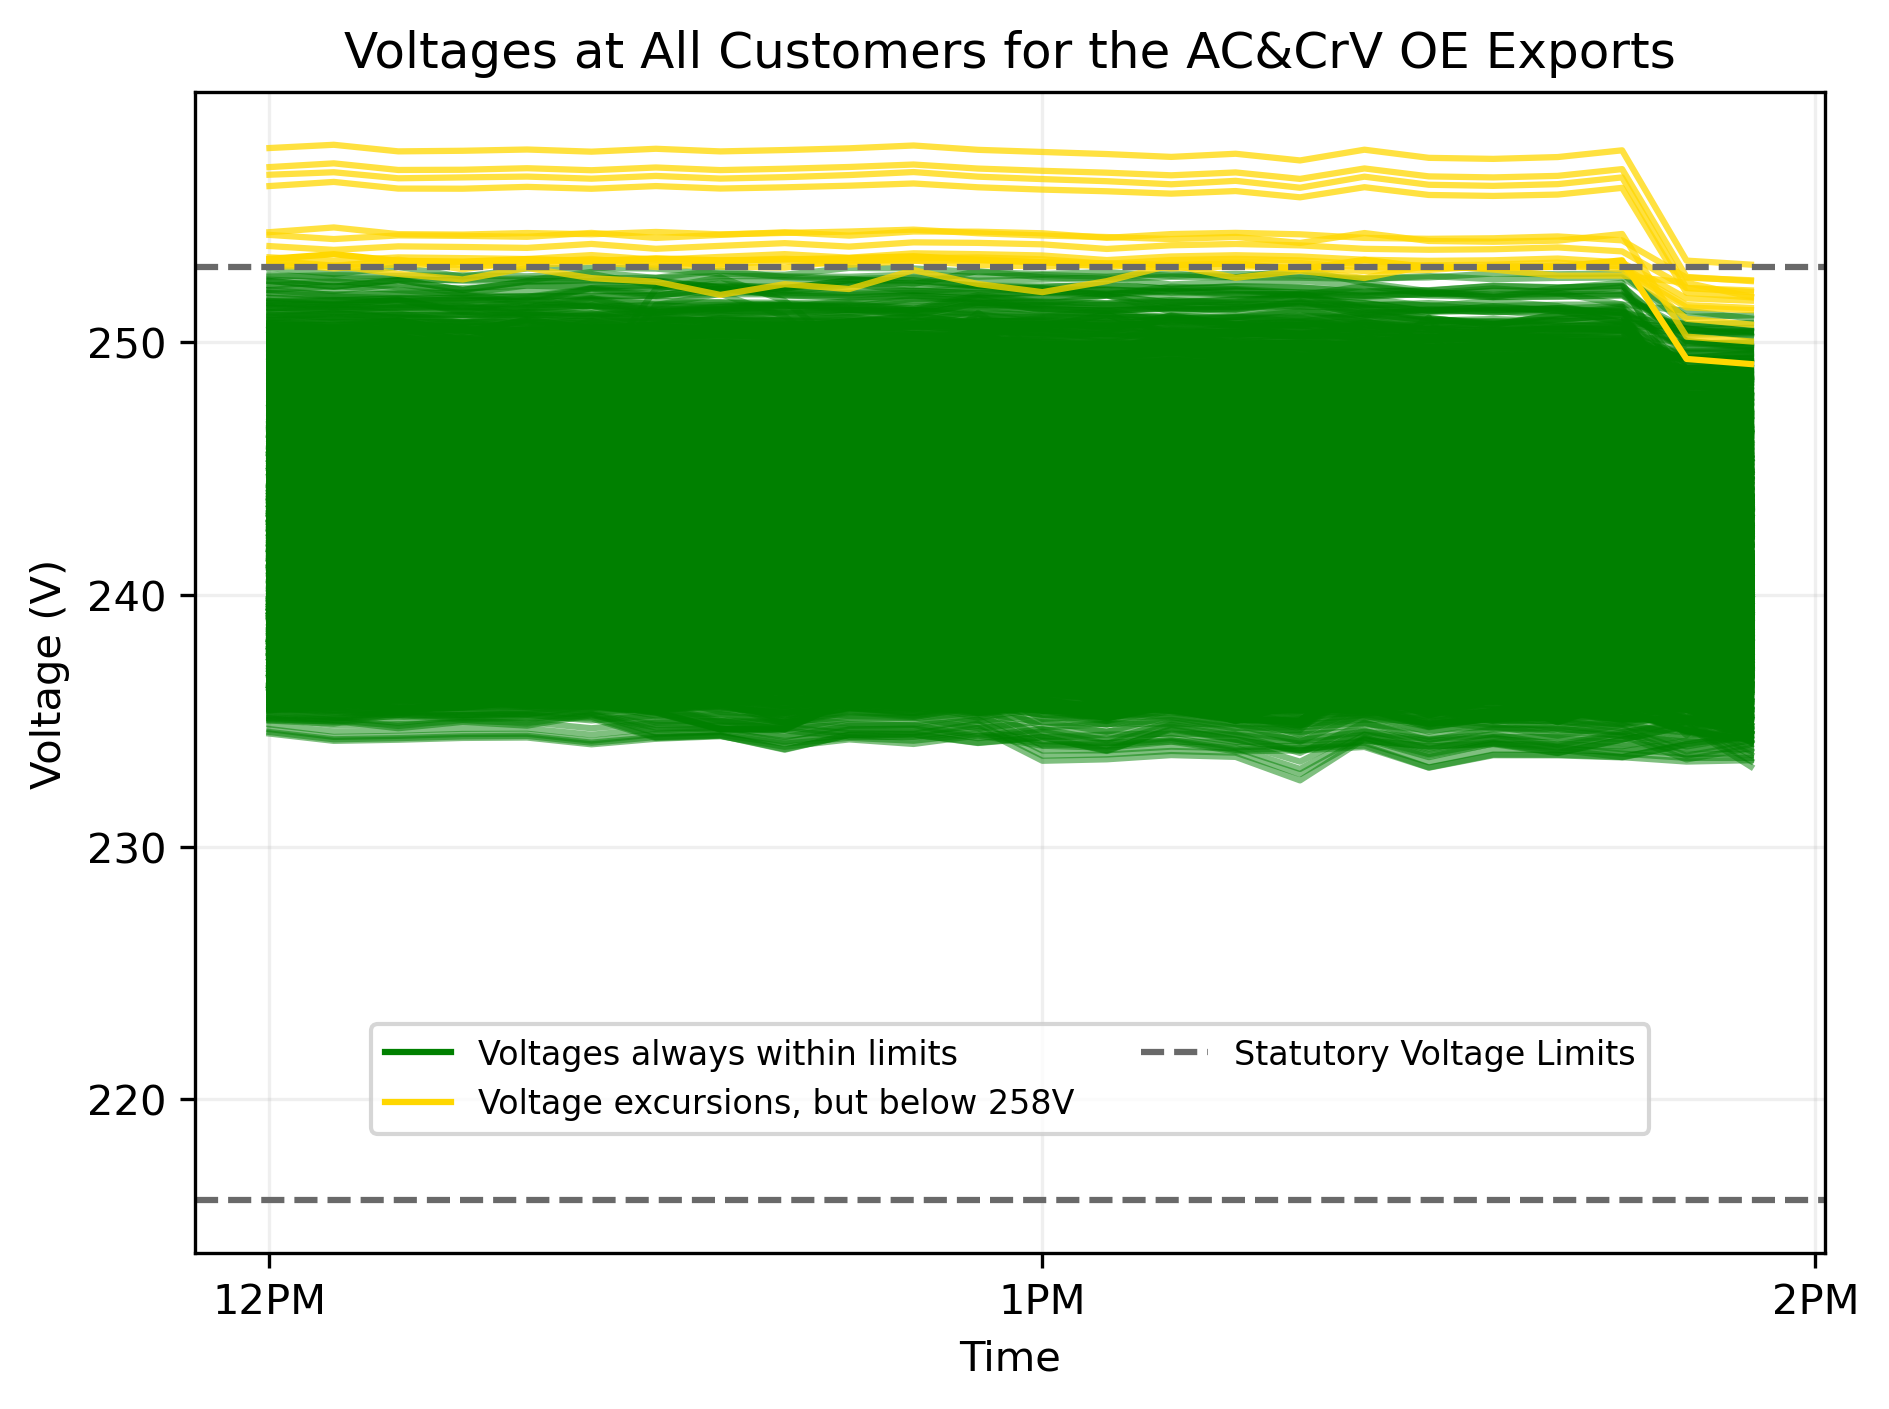

The network-wide voltage compliance is: 99.61572568725983%
Comments about the info above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:
- Almost all customers (more than 99%) have voltages always within limits (below 253V).
- Extremely few customers (less than 0.5%) have voltages above the standard limits (253V, in yellow), but not above the inverter tripping point (258V).
- The network-wide voltage compliance (which includes the MV feeder and all LV networks) is around 99%, which is above the standard limit of 95%.
- The Asset Capacity & Critical Voltage OE Exports with Integrated MV-LV Calculation could keep all voltages within acceptable values.


In [12]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Calculation of the network-wide voltage compliance
    v_all_cust_10min = np.zeros((len(load_names), int(24/2)), float)
    v_all_cust_10min_sorted = np.zeros((len(load_names), int(24/2)), float)
    count = 0
    for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
        for itime in range(int(24/2)): 
            # calculate the 10 minutes voltage equivalent (current time step is of 5 minutes)
            v_all_cust_10min[ild, itime] = (save_all_voltage_profiles[ild, 2*itime] + save_all_voltage_profiles[ild, 2*itime+1]) / 2
        v_all_cust_10min_sorted[ild,:] = np.sort(v_all_cust_10min[ild, :]) # sort the voltages of each customer from small to high
        # check if the 99 percentile if outside the limits
        if (v_all_cust_10min_sorted[ild, 11] > 253) or (v_all_cust_10min_sorted[ild, 0] < 216):
            count += 1 # if outside the limits, count the customer as non-compliant

    v_network_compliance = (1 - ((count) / len(load_names))) * 100 # calculate the network-wide voltage compliance



    # Plot voltages in all customers
    x = range(24)
    y1 = save_all_voltage_profiles
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Voltages at All Customers for the AC&CrV OE Exports")
    plt.ylabel("Voltage (V)")
    plt.xlabel("Time")
    for ild in range(len(load_names)):
        if (y1[ild, :] <= 253.049).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[ild, :24], color='green', alpha=1, label='Voltages always within limits') 
                green_count += 1
            else:
                plt.plot(x, y1[ild, :24], color='green', alpha=0.5)
    for ild in range(len(load_names)):    
        if (y1[ild, :] > 253.049).any() and (y1[ild, :] <= 258.049).all():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[ild, :24], color='gold', alpha=1, label='Voltage excursions, but below 258V') 
                yellow_count += 1
            else:
                plt.plot(x, y1[ild, :24], color='gold', alpha=0.75)
    for ild in range(len(load_names)):    
        if (y1[ild, :] > 258.049).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[ild, :24], color='red', alpha=1, label='Voltages excursions above 258V') 
                red_count =+ 1
            else:
                plt.plot(x, y1[ild, :24], color='red', alpha=0.75)
    plt.axhline(y = 253, color = 'dimgrey', linestyle = 'dashed', label='Statutory Voltage Limits')
    plt.axhline(y = 216, color = 'dimgrey', linestyle = 'dashed')
    plt.grid(alpha=0.2)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.legend(loc='center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.15, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('The network-wide voltage compliance is: '+str(v_network_compliance)+'%')
    print('Comments about the info above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:')
    print('- Almost all customers (more than 99%) have voltages always within limits (below 253V).')
    print('- Extremely few customers (less than 0.5%) have voltages above the standard limits (253V, in yellow), but not above the inverter tripping point (258V).')
    print('- The network-wide voltage compliance (which includes the MV feeder and all LV networks) is around 99%, which is above the standard limit of 95%.')
    print('- The Asset Capacity & Critical Voltage OE Exports with Integrated MV-LV Calculation could keep all voltages within acceptable values.')

    


if full_simulation == 1: # full three days simulation (simulates 72h)
    # Calculation of the network-wide voltage compliance
    v_all_cust_10min = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
    v_all_cust_10min_sorted = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
    count = 0
    for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
        for itime in range(int(num_time_steps*num_days/2)): 
            # calculate the 10 minutes voltage equivalent (current time step is of 5 minutes)
            v_all_cust_10min[ild, itime] = (save_all_voltage_profiles[ild, 2*itime] + save_all_voltage_profiles[ild, 2*itime+1]) / 2
        v_all_cust_10min_sorted[ild,:] = np.sort(v_all_cust_10min[ild, :]) # sort the voltages of each customer from small to high
        # check if the 99 percentile if outside the limits
        if (v_all_cust_10min_sorted[ild, 142] > 253) or (v_all_cust_10min_sorted[ild, 1] < 216):
            count += 1 # if outside the limits, count the customer as non-compliant

    v_network_compliance = (1 - ((count) / len(load_names))) * 100 # calculate the network-wide voltage compliance



    # Plot voltages in all customers
    x = range(num_time_steps*num_days)
    y1 = save_all_voltage_profiles
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
    
    plt.figure(figsize=(8, 6), dpi=300)
    ax = plt.axes()
    plt.title("Voltages at All Customers for the AC&CrV OE Exports")
    plt.ylabel("Voltage (V)")
    plt.xlabel("Time")
    for ild in range(len(load_names)):
        if (y1[ild, :] <= 253.049).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[ild, :], color='green', alpha=1, label='Voltages always within limits') 
                green_count += 1
            else:
                plt.plot(x, y1[ild, :], color='green', alpha=0.5)
    for ild in range(len(load_names)):    
        if (y1[ild, :] > 253.049).any() and (y1[ild, :] <= 258.049).all():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[ild, :], color='gold', alpha=1, label='Voltage excursions, but below 258V') 
                yellow_count += 1
            else:
                plt.plot(x, y1[ild, :], color='gold', alpha=0.75)
    for ild in range(len(load_names)):    
        if (y1[ild, :] > 258.049).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[ild, :], color='red', alpha=1, label='Voltages excursions above 258V') 
                red_count =+ 1
            else:
                plt.plot(x, y1[ild, :], color='red', alpha=0.75)
    plt.axhline(y = 253, color = 'dimgrey', linestyle = 'dashed', label='Statutory Voltage Limits')
    plt.axhline(y = 216, color = 'dimgrey', linestyle = 'dashed')
    plt.grid(alpha=0.2)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.legend(loc='center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.15, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('The network-wide voltage compliance is: '+str(v_network_compliance)+'%')
    print('Comments about the info above, which considers low-mid penetration (15%) of flexible customers for the three simulated days (summer):')
    print('- Most customers (~98%) have voltages always within limits (below 253V).')
    print('- Very few customers (~2%) have voltages above the standard limits (253V, in yellow), but not above the inverter tripping point (258V).')
    print('- Extremely few customers (less than 0.1%) have voltages way too high (above 258V, in red).')
    print('- The network-wide voltage compliance (which includes the MV feeder and all LV networks) is higher than 99%, which is above the standard limit of 95%.')
    print('- The Asset Capacity & Critical Voltage OE Exports with Integrated MV-LV Calculation could not keep all voltages within the standard limits (note that this OE is not designed to solve voltage issues), but the network-wide voltage compliance is within requirements (equal or above 95%).')

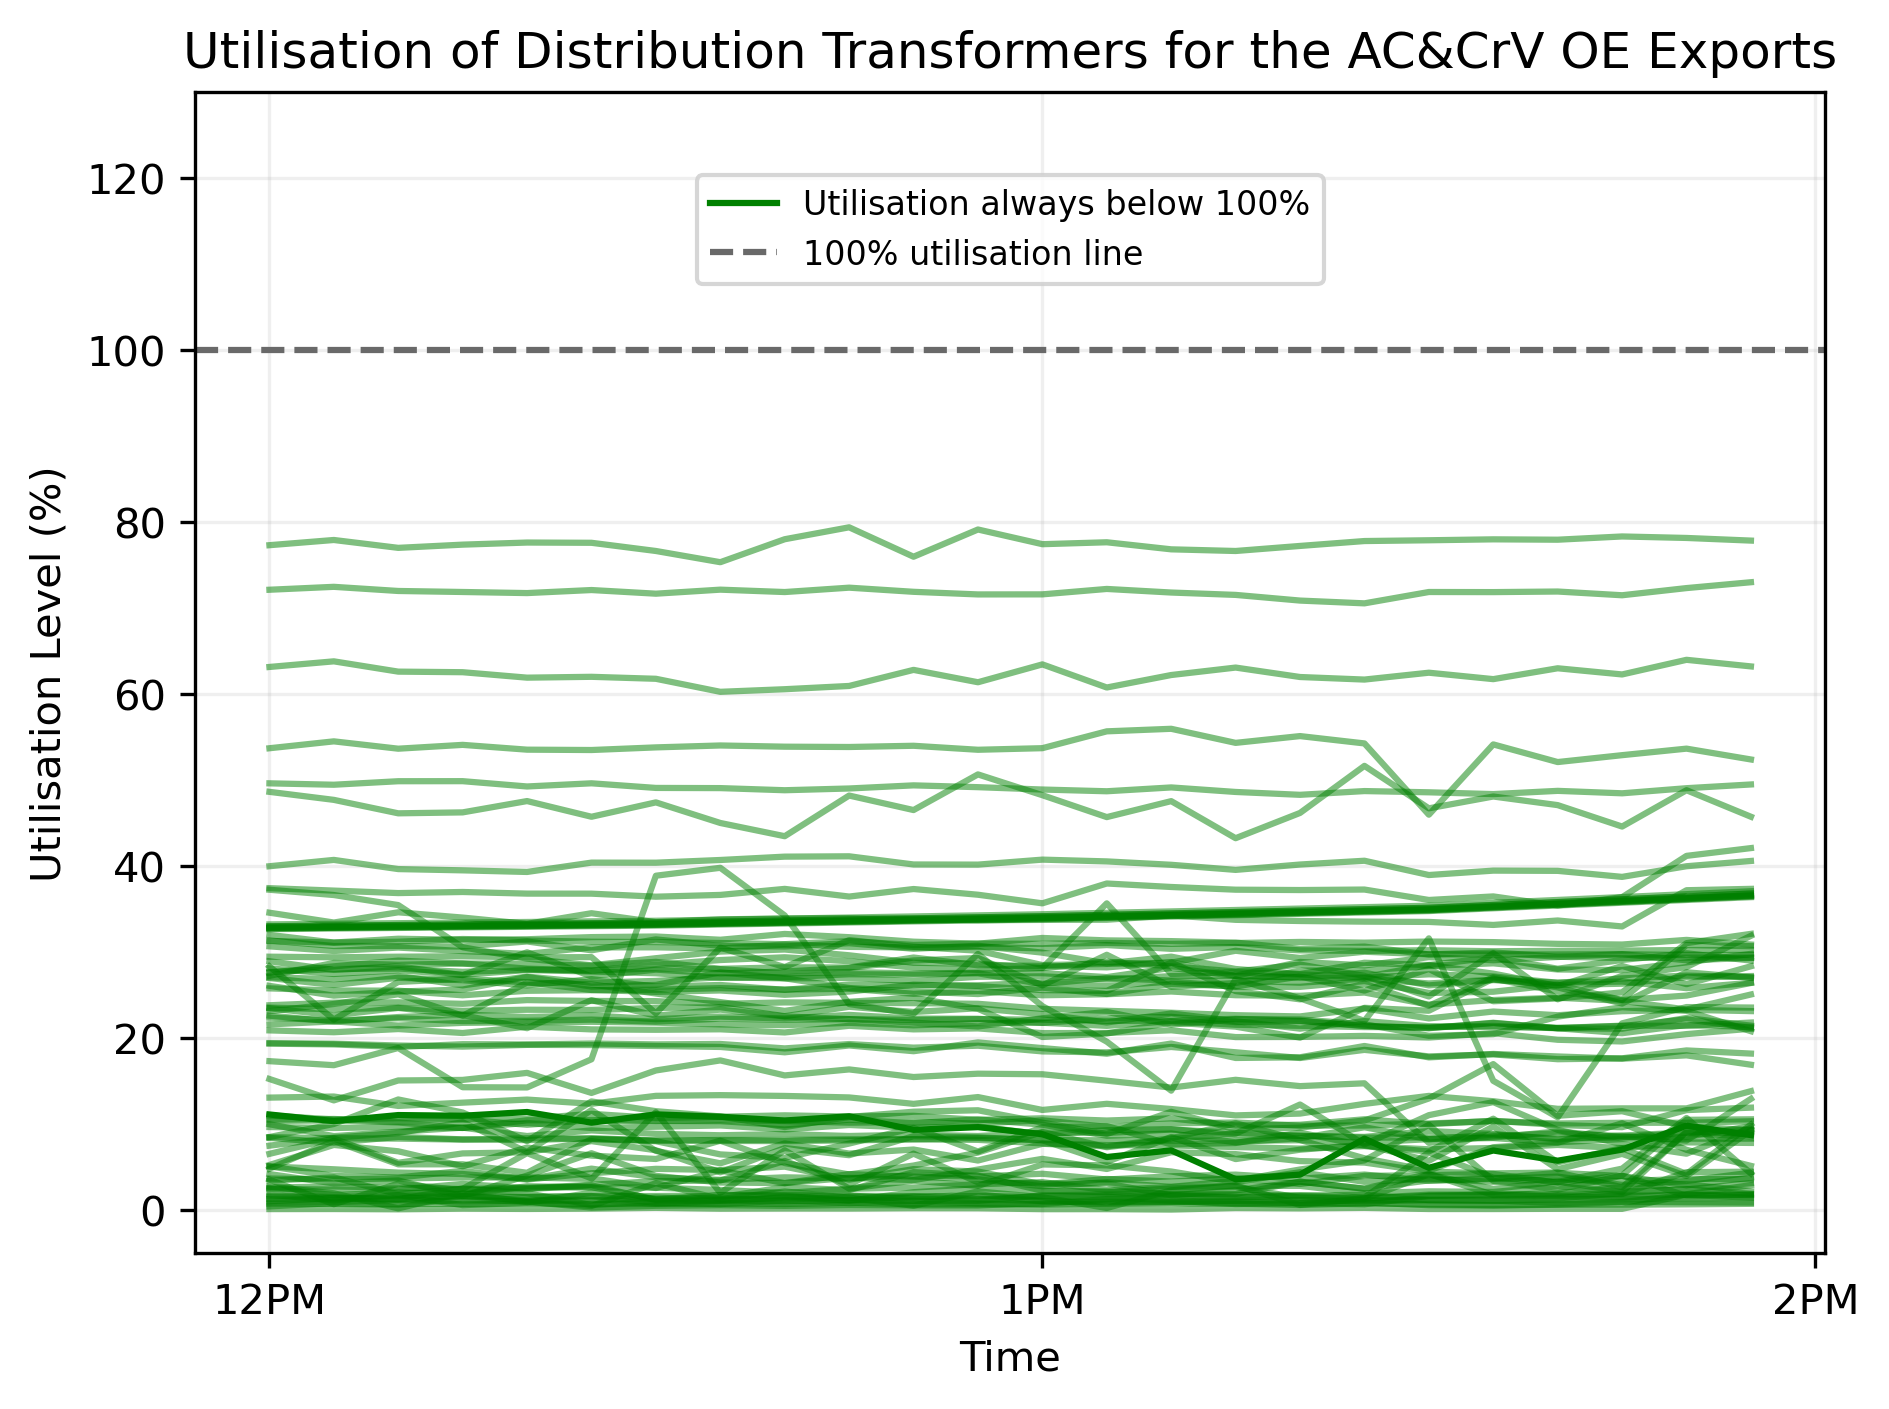

Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:
- The utilisation of all distribution transformers are within the required limits.
- The Asset Capacity & Critical Voltage OE Exports with Integrated MV-LV Calculation could maintain distribution transformers under the required utilisation levels.


In [16]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Plot utilisation of all distribution transformers
    x = range(24)
    y1 = save_lvtx_util
    red_count = 0
    yellow_count = 0
    green_count = 0
    
    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilisation of Distribution Transformers for the AC&CrV OE Exports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        if (y1[itx] <= 100.49).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[itx][:24], color='green', alpha=1, label='Utilisation always below 100%') 
                green_count += 1
            else:
                plt.plot(x, y1[itx][:24], color='green', alpha=0.5)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 100.49).any() and (y1[itx] <= 110.49).all():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[itx][:24], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                yellow_count += 1
            else:
                plt.plot(x, y1[itx][:24], color='gold', alpha=0.75)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 110.49).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[itx][:24], color='red', alpha=1, label='Utilisation above 110%') 
                red_count =+ 1
            else:
                plt.plot(x, y1[itx][:24], color='red', alpha=0.75)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 130)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.82, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:')
    print('- The utilisation of all distribution transformers are within the required limits.')
    print('- The Asset Capacity & Critical Voltage OE Exports with Integrated MV-LV Calculation could maintain distribution transformers under the required utilisation levels.')

    


if full_simulation == 1: # full three days simulation (simulates 72h)
    # Plot utilisation of all distribution transformers
    x = range(num_time_steps*num_days)
    y1 = save_lvtx_util
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilisation of Distribution Transformers for the AC&CrV OE Exports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        if (y1[itx] <= 100.49).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[itx], color='green', alpha=1, label='Utilisation always below 100%') 
                green_count += 1
            else:
                plt.plot(x, y1[itx], color='green', alpha=0.5)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 100.49).any() and (y1[itx] <= 110.49).all():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[itx], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                yellow_count += 1
            else:
                plt.plot(x, y1[itx], color='gold', alpha=0.75)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 110.49).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[itx], color='red', alpha=1, label='Utilisation above 110%') 
                red_count =+ 1
            else:
                plt.plot(x, y1[itx], color='red', alpha=0.75)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 130)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.82, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for the three simulated days (summer):')
    print('- The utilisation of almost all distribution transformers (~97%) are always within the required limits.')
    print('- Only 2 distribution transformers go above the 100% utilisation. However, the highest value above the limits is below 2%, which is perfectly acceptable under real operational conditions.')
    print('- The Asset Capacity & Critical Voltage OE Exports with Integrated MV-LV Calculation could maintain distribution transformers under acceptable utilisation levels.')

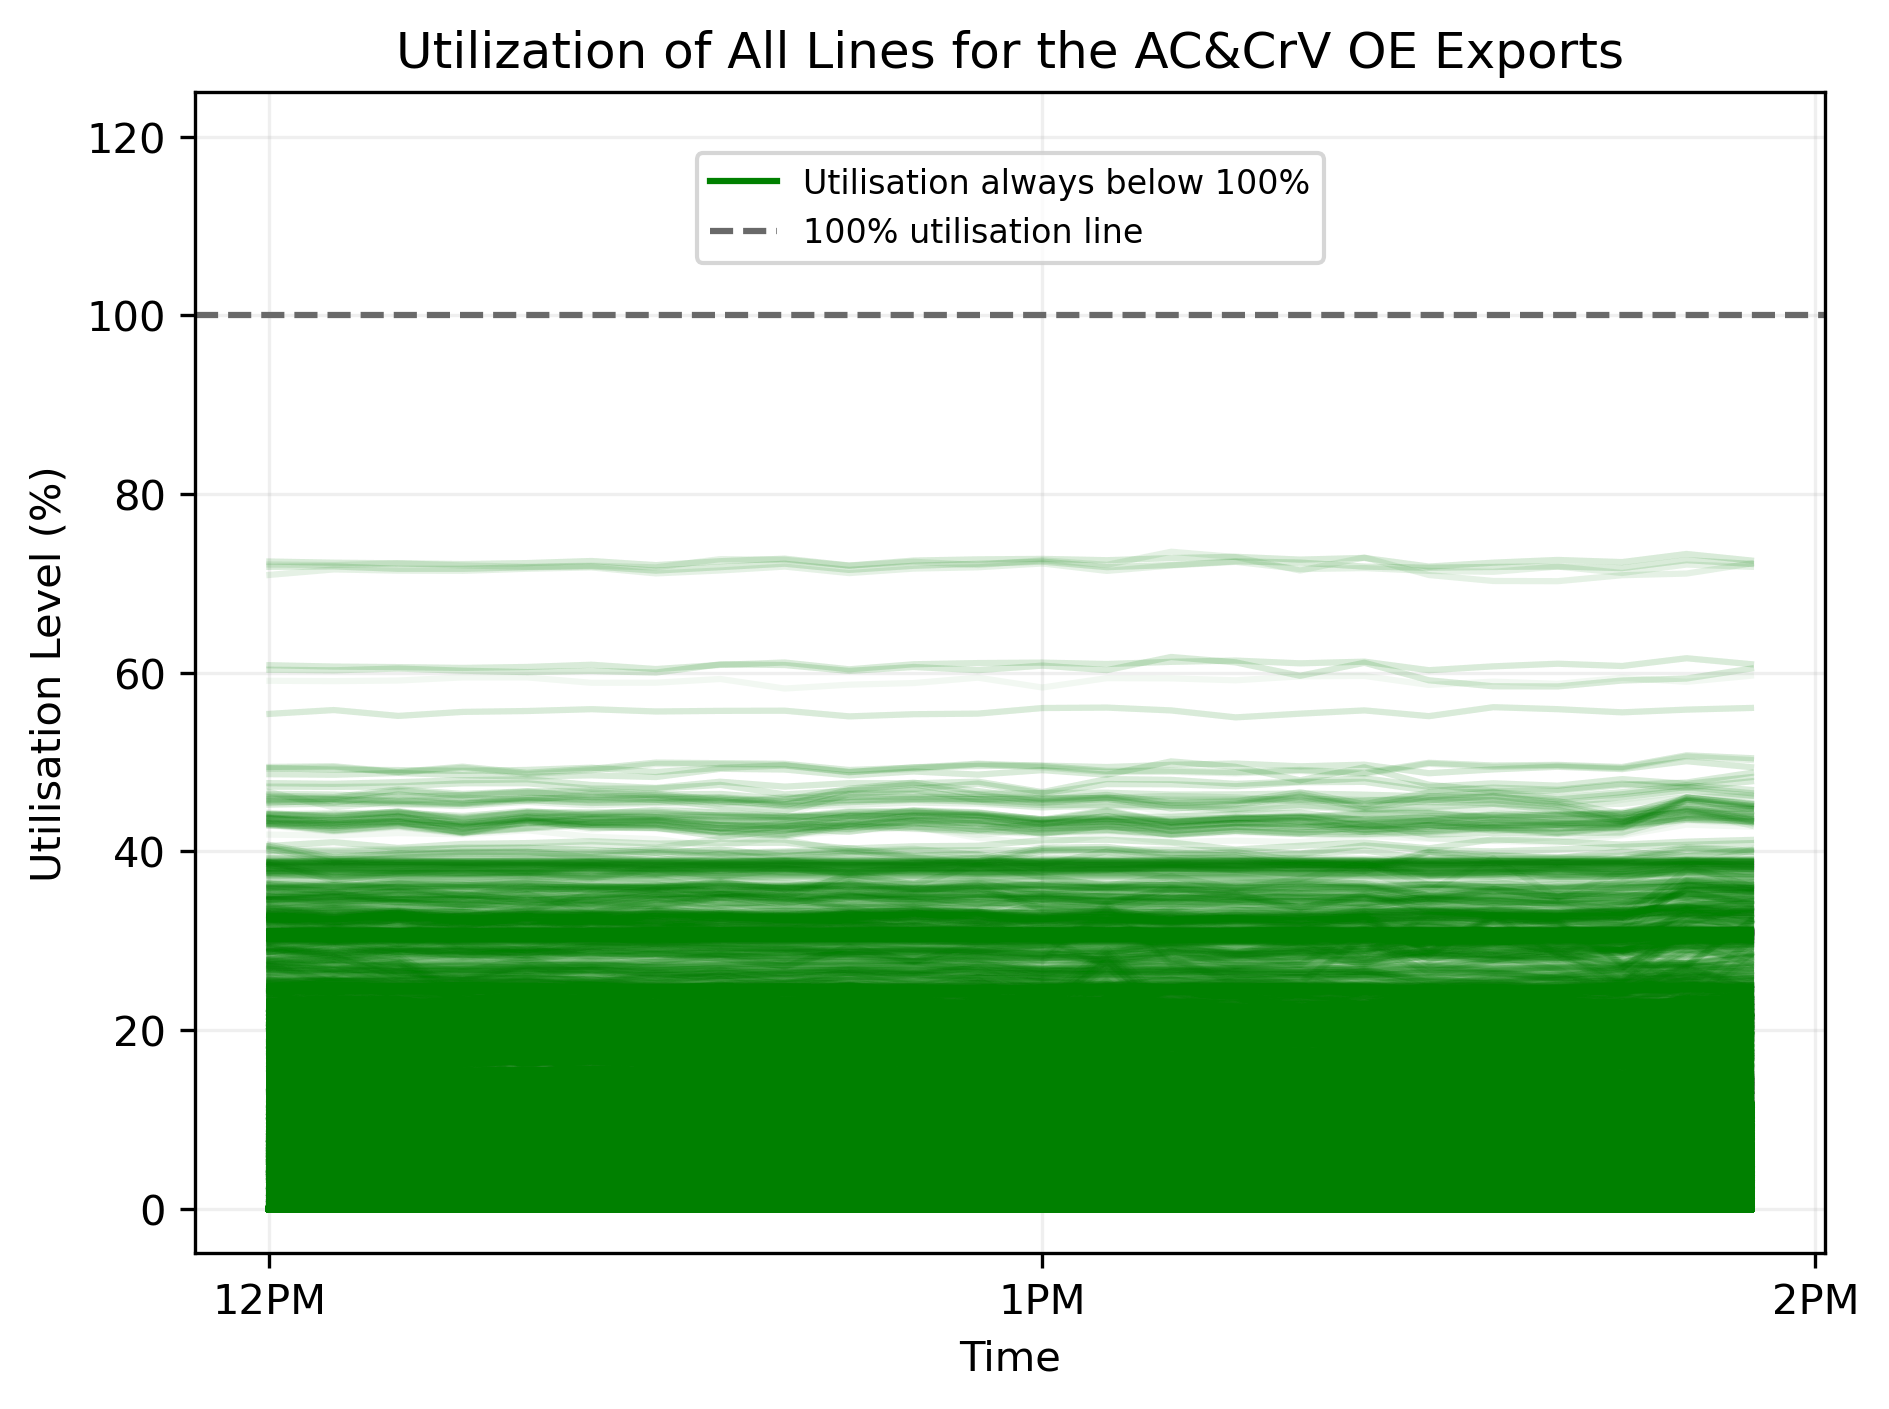

Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:
- The utilisation of all MV and LV lines are within the required utilisation limits.


In [20]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Plot utilisation of all MV and LV lines
    x = range(24)
    y1 = save_lines_util
    green_count = 0
    yellow_count = 0
    red_count = 0

    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilization of All Lines for the AC&CrV OE Exports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for iln in range(len(y1)):
        for iph in range(3):
            if (y1[iln, iph, :] <= 100.49).all():
                if green_count == 0:
                    plt.plot(x, y1[iln, iph, :24], color='green', alpha=1, label='Utilisation always below 100%') 
                    green_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :24], color='green', alpha=0.05)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 100.49).any() and (y1[iln, iph, :] <= 110.49).all():
                if yellow_count == 0:
                    plt.plot(x, y1[iln, iph, :24], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                    yellow_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :24], color='gold', alpha=0.2)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 110.49).any():
                if red_count == 0:
                    plt.plot(x, y1[iln, iph, :24], color='red', alpha=1, label='Utilisation above 110%') 
                    red_count =+ 1
                else:
                    plt.plot(x, y1[iln, iph, :24], color='red', alpha=0.2)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 125)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.legend(loc='center', fontsize=8, bbox_to_anchor=(0.5, 0.9, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:')
    print('- The utilisation of all MV and LV lines are within the required utilisation limits.')


    
    
if full_simulation == 1: # full three days simulation (simulates 72h)
    # Plot utilisation of all MV and LV lines
    x = range(num_time_steps*num_days)
    y1 = save_lines_util
    green_count = 0
    yellow_count = 0
    red_count = 0

    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilization of All Lines for the AC&CrV OE Exports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for iln in range(len(y1)):
        for iph in range(3):
            if (y1[iln, iph, :] <= 100.49).all():
                if green_count == 0:
                    plt.plot(x, y1[iln, iph, :], color='green', alpha=1, label='Utilisation always below 100%') 
                    green_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :], color='green', alpha=0.05)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 100.49).any() and (y1[iln, iph, :] <= 110.49).all():
                if yellow_count == 0:
                    plt.plot(x, y1[iln, iph, :], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                    yellow_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :], color='gold', alpha=0.2)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 110.49).any():
                if red_count == 0:
                    plt.plot(x, y1[iln, iph, :], color='red', alpha=1, label='Utilisation above 110%') 
                    red_count =+ 1
                else:
                    plt.plot(x, y1[iln, iph, :], color='red', alpha=0.2)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 125)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.legend(loc='center', fontsize=8, bbox_to_anchor=(0.5, 0.9, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for the three simulated days (summer):')
    print('- The utilisation of all MV and LV lines are always within the required utilisation limits.')

#### Implementation of the Calculated Asset Capacity & Critical Voltage OE Import

In [21]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Re-load the integrated MV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
    dss_text.Command = 'Clear'
    dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
    dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
    dss_text.Command = 'calcv'
    dss_text.Command = 'Set ControlMode=static'
    dss_text.Command = 'Reset'                                                     
    dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

    # Extract names of all lines from OpenDSS
    line_names = dss_circuit.Lines.AllNames

    # Extract names of all loads from the OpenDSS
    load_names = dss_circuit.Loads.AllNames

    # Extract names of all distribution transformers from the OpenDSS
    transformer_names = dss_circuit.Transformers.AllNames

    # initialise arrays to save simulation results for each time step
    save_lvtx_util = np.zeros((num_distr_tx, num_time_steps*num_days), float) # save utilisation of all distribution transformers in the integrated MV-LV network
    save_lines_util = np.zeros((len(line_names), 3, num_time_steps*num_days), float) # save utilisation of all lines in the integrated MV-LV network
    save_all_voltage_profiles = np.zeros((len(load_names), num_time_steps*num_days), float) # save voltages of all customers connected to the integrated MV-LV network

    # Implement the calculated OE value for each time step in a for loop
    for itime in range(24):

        if itime == 0:
            dss_solution.Hour = 4 # Setting OpenDSS to simulate from specific hour (start at 12h of the first day of simulation)            
            print('You are checking the calculated OE of the first day for 2h, starting from 12PM.\nThis should take less than a minute to finish, but simulation time vary for different computers.')
        
        dss_solution.Solve() # solve the power flow in OpenDSS

    
        for nlv in range(num_distr_tx): # loop in each existing LV network of the integrated MV-LV network
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer on the LV network
                # Deactivate PV system element of flexible customers (OE export is going to be modelled as negative load next)
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # deactivate PV system in OpenDSS
       
                # Implement the calculated operating envelopes to flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the flexible customer active in OpenDSS
                    temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
                    dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(save_ac_crv_oe_prop_imp_values[itime][0][nlv][ild]) # set the kW to the allocated import OE value
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before


        dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step
    
    
    
        # Distribution transformers utilisation 
        for itx in range(num_distr_tx): # loop in all distribution transformers of the integrated MV-LV network
            dss_circuit.SetActiveElement('transformer.' + str(transformer_names[itx+1])) # Set the distribution transformer active in OpenDSS
            number_phases = int(dss_circuit.ActiveElement.Properties('phases').Val) # Extract the number of phases of the distribution transformer from OpenDSS
            if number_phases == 3: # Extract power from three-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # Extract the three-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # Extract the three-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the three-phase apparent power at the secondary of the distribution transformer
            if number_phases == 1: # Extract power from single-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # Extract the single-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # Extract the single-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the single-phase apparent power at the secondary of the distribution transformer

            # calculate the utilisation of distribution transformers
            lv_tx_util_temp = 100 * S2_LVTx_temp / all_lvtx_capacity[itx]
            save_lvtx_util[itx, itime] = lv_tx_util_temp 
        
        

        # Lines utilisation (both MV and LV)
        for iln in range(len(line_names)): # loop in all lines of the integrated MV-LV network
            if (line_names[iln][8:10] == '5_' or line_names[iln][8:10] == '6_' or line_names[iln][8:10] == '9_' 
                or line_names[iln][8:10] == '10' or line_names[iln][8:10] == '12' or line_names[iln][8:10] == '15' 
                or line_names[iln][8:10] == '18' or line_names[iln][8:10] == '37' or line_names[iln][8:10] == '48'): # these are lines for commercial customers (they are never flexible customers in the case study), so no thermal issues
                pass
            else:
                line_util_temp = []
                dss_circuit.SetActiveElement('line.' + str(line_names[iln])) # Set the line active in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # Extract the current at phase A from the OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # Extract the current at phase B from the OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # Extract the current at phase C from the OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # Extract the rated capacity (amps) of the line (per phase)

                # calculate the line utilisation in each phase
                line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
                save_lines_util[iln, :, itime] = line_util_temp



        # Voltages at all customers of the integrated MV-LV network
        for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
            dss_circuit.SetActiveElement('load.' + str(load_names[ild])) # Set the customer active in OpenDSS
            temp_v = dss_circuit.ActiveElement.VoltagesMagAng # Extract the voltage at the customer from OpenDSS
            save_all_voltage_profiles[ild, itime] = temp_v[0]



        # Reset flexible customers to their original settings for the next time step
        for nlv in range(79):
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer in the LV network
                # Reactivate PV systems for flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])):
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'true' # Reactivate the PV system
    
                # Reset flexible customers to profile values for the next time step
                default_kw_kvar = 1
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in all customers of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set customer active in OpenDSS
                    dss_circuit.ActiveElement.Properties('status').Val = 'variable' # Set the load to follow its original profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)
    print('Simulation finished. The performance metrics were saved and they can be visualised in the code cells below.')


    
    
if full_simulation == 1: # full three days simulation (simulates 72h)
    # Re-load the integrated MV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
    dss_text.Command = 'Clear'
    dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
    dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
    dss_text.Command = 'calcv'
    dss_text.Command = 'Set ControlMode=static'
    dss_text.Command = 'Reset'                                                     
    dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

    # Extract names of all lines from OpenDSS
    line_names = dss_circuit.Lines.AllNames

    # Extract names of all loads from the OpenDSS
    load_names = dss_circuit.Loads.AllNames

    # Extract names of all distribution transformers from the OpenDSS
    transformer_names = dss_circuit.Transformers.AllNames

    # initialise arrays to save simulation results for each time step
    save_lvtx_util = np.zeros((num_distr_tx, num_time_steps*num_days), float) # save utilisation of all distribution transformers in the integrated MV-LV network
    save_lines_util = np.zeros((len(line_names), 3, num_time_steps*num_days), float) # save utilisation of all lines in the integrated MV-LV network
    save_all_voltage_profiles = np.zeros((len(load_names), num_time_steps*num_days), float) # save voltages of all customers connected to the integrated MV-LV network

    # Implement the calculated OE value for each time step in a for loop
    for itime in range(num_time_steps*num_days):

        if itime == 0:
            print('You are checking the calculated OE for three complete days.\nThis can take up to 2 hours to finish (if you also updated the OE reduction step to 1%), but simulation time vary for different computers.')        
        
        dss_solution.Solve() # solve the power flow in OpenDSS

    
        for nlv in range(num_distr_tx): # loop in each existing LV network of the integrated MV-LV network
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer on the LV network
                # Deactivate PV system element of flexible customers (OE export is going to be modelled as negative load next)
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # deactivate PV system in OpenDSS
       
                # Implement the calculated operating envelopes to flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the flexible customer active in OpenDSS
                    temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
                    dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(save_ac_crv_oe_prop_imp_values[itime][0][nlv][ild]) # set the kW to the allocated import OE value
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before


        dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step
    
    
    
        # Distribution transformers utilisation 
        for itx in range(num_distr_tx): # loop in all distribution transformers of the integrated MV-LV network
            dss_circuit.SetActiveElement('transformer.' + str(transformer_names[itx+1])) # Set the distribution transformer active in OpenDSS
            number_phases = int(dss_circuit.ActiveElement.Properties('phases').Val) # Extract the number of phases of the distribution transformer from OpenDSS
            if number_phases == 3: # Extract power from three-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # Extract the three-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # Extract the three-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the three-phase apparent power at the secondary of the distribution transformer
            if number_phases == 1: # Extract power from single-phase distribution transformers
                P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # Extract the single-phase active power at the secondary of the distribution transformer from OpenDSS
                Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # Extract the single-phase reactive power at the secondary of the distribution transformer from OpenDSS
                S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the single-phase apparent power at the secondary of the distribution transformer

            # calculate the utilisation of distribution transformers
            lv_tx_util_temp = 100 * S2_LVTx_temp / all_lvtx_capacity[itx]
            save_lvtx_util[itx, itime] = lv_tx_util_temp 
        
        

        # Lines utilisation (both MV and LV)
        for iln in range(len(line_names)): # loop in all lines of the integrated MV-LV network
            if (line_names[iln][8:10] == '5_' or line_names[iln][8:10] == '6_' or line_names[iln][8:10] == '9_' 
                or line_names[iln][8:10] == '10' or line_names[iln][8:10] == '12' or line_names[iln][8:10] == '15' 
                or line_names[iln][8:10] == '18' or line_names[iln][8:10] == '37' or line_names[iln][8:10] == '48'): # these are lines for commercial customers (they are never flexible customers in the case study), so no thermal issues
                pass
            else:
                line_util_temp = []
                dss_circuit.SetActiveElement('line.' + str(line_names[iln])) # Set the line active in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # Extract the current at phase A from the OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # Extract the current at phase B from the OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], 
                              dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # Extract the current at phase C from the OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # Extract the rated capacity (amps) of the line (per phase)

                # calculate the line utilisation in each phase
                line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
                save_lines_util[iln, :, itime] = line_util_temp



        # Voltages at all customers of the integrated MV-LV network
        for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
            dss_circuit.SetActiveElement('load.' + str(load_names[ild])) # Set the customer active in OpenDSS
            temp_v = dss_circuit.ActiveElement.VoltagesMagAng # Extract the voltage at the customer from OpenDSS
            save_all_voltage_profiles[ild, itime] = temp_v[0]



        # Reset flexible customers to their original settings for the next time step
        for nlv in range(79):
            if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer in the LV network
                # Reactivate PV systems for flexible customers
                for ild in range(len(all_flex_cust_names_per_lv[nlv])):
                    dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set PV system active in OpenDSS
                    dss_circuit.ActiveElement.Properties('enabled').Val = 'true' # Reactivate the PV system
    
                # Reset flexible customers to profile values for the next time step
                default_kw_kvar = 1
                for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in all customers of the LV network
                    dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set customer active in OpenDSS
                    dss_circuit.ActiveElement.Properties('status').Val = 'variable' # Set the load to follow its original profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)
    print('Simulation finished. The performance metrics were saved and they can be visualised in the code cells below.')

You are checking the calculated OE of the first day for 2h, starting from 12PM.
This should take less than a minute to finish, but simulation time vary for different computers.
Simulation finished. The performance metrics were saved and they can be visualised in the code cells below.


#### Technical Assessment of the Calculated Asset Capacity & Critical Voltage OE import

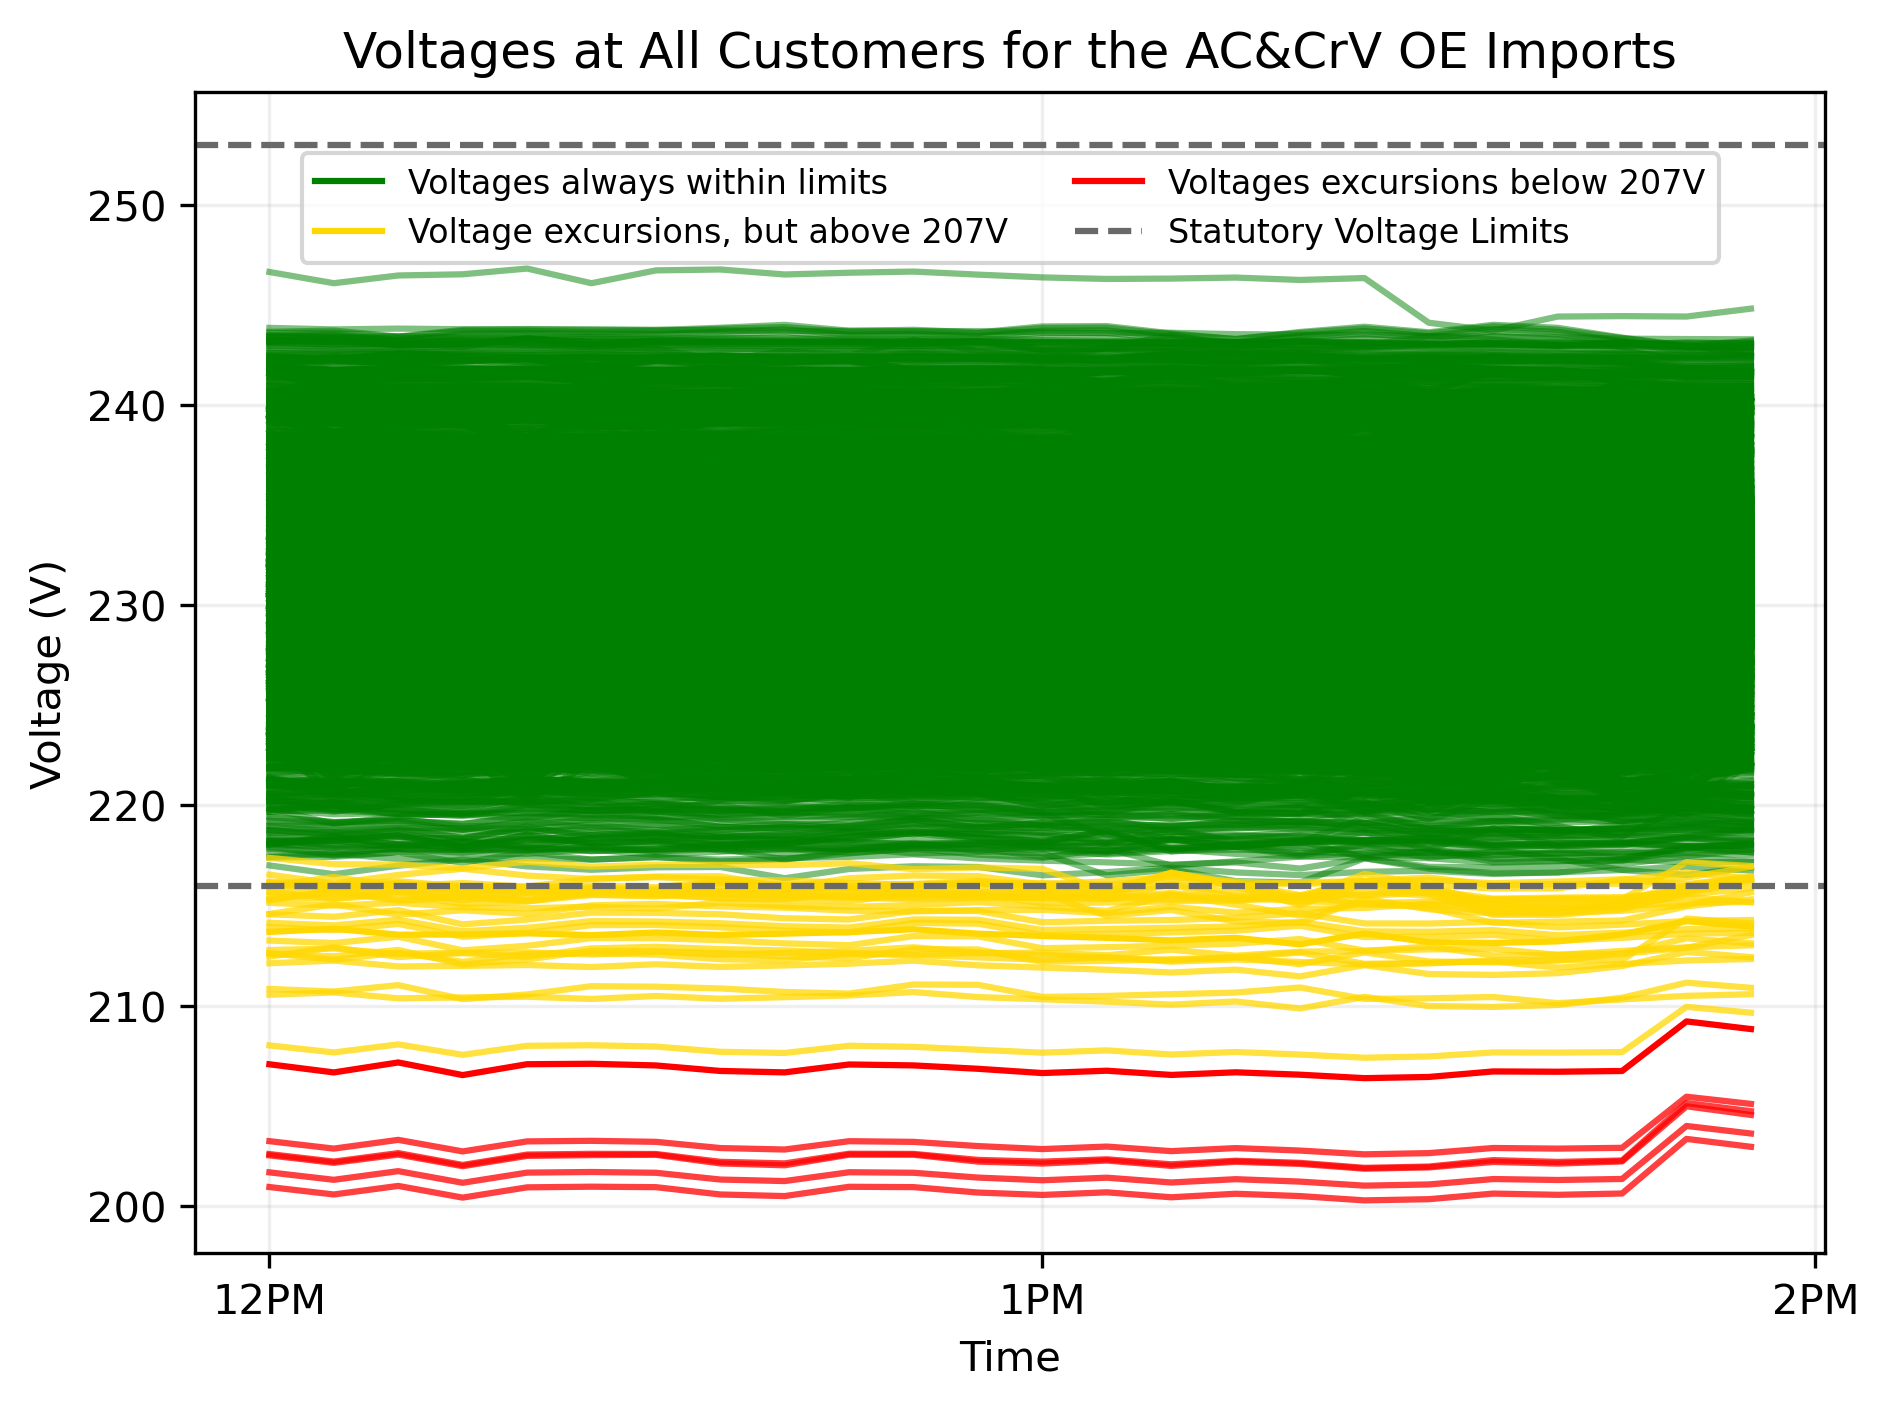

The network-wide voltage compliance is: 99.0540939994088%
Comments about the info above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:
- Most customers (~99%) have voltages always within limits (above 216V).
- Extremely few customers (less than 1%) have voltages below the standard limits (216V, in yellow), but not below the voltage dip limit (207V).
- Extremely few customers (less than 0.5%) have voltages way too low (below 207V, in red).
- The network-wide voltage compliance (which includes the MV feeder and all LV networks) is around 99%, which is within the standard limit of 95%.
- The Asset Capacity & Critical Voltage OE Imports with Integrated MV-LV Calculation could not keep all voltages within the standard limits, but the network-wide voltage compliance is within requirements (equal or higher than 95%).


In [22]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Calculation of the network-wide voltage compliance
    v_all_cust_10min = np.zeros((len(load_names), int(24/2)), float)
    v_all_cust_10min_sorted = np.zeros((len(load_names), int(24/2)), float)
    count = 0
    for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
        for itime in range(int(24/2)): 
            # calculate the 10 minutes voltage equivalent (current time step is of 5 minutes)
            v_all_cust_10min[ild, itime] = (save_all_voltage_profiles[ild, 2*itime] + save_all_voltage_profiles[ild, 2*itime+1]) / 2
        v_all_cust_10min_sorted[ild,:] = np.sort(v_all_cust_10min[ild, :]) # sort the voltages of each customer from small to high
        # check if the 99 percentile if outside the limits
        if (v_all_cust_10min_sorted[ild, 11] > 253) or (v_all_cust_10min_sorted[ild, 0] < 216):
            count += 1 # if outside the limits, count the customer as non-compliant

    v_network_compliance = (1 - ((count) / len(load_names))) * 100 # calculate the network-wide voltage compliance


    
    # Plot voltages in all customers
    x = range(24)
    y1 = save_all_voltage_profiles
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0    
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Voltages at All Customers for the AC&CrV OE Imports")
    plt.ylabel("Voltage (V)")
    plt.xlabel("Time")
    for ild in range(len(load_names)):
        if (y1[ild, :24] >= 215.96).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[ild, :24], color='green', alpha=1, label='Voltages always within limits') 
                green_count += 1
            else:
                plt.plot(x, y1[ild, :24], color='green', alpha=0.5)
    for ild in range(len(load_names)):    
        if (y1[ild, :24] > 206.96).all() and (y1[ild, :24] < 215.96).any():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[ild, :24], color='gold', alpha=1, label='Voltage excursions, but above 207V') 
                yellow_count += 1
            else:
                plt.plot(x, y1[ild, :24], color='gold', alpha=0.75)
    for ild in range(len(load_names)):    
        if (y1[ild, :24] < 206.96).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[ild, :24], color='red', alpha=1, label='Voltages excursions below 207V') 
                red_count =+ 1
            else:
                plt.plot(x, y1[ild, :24], color='red', alpha=0.75)
    plt.axhline(y = 253, color = 'dimgrey', linestyle = 'dashed', label='Statutory Voltage Limits')
    plt.axhline(y = 216, color = 'dimgrey', linestyle = 'dashed')
    plt.grid(alpha=0.2)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.legend(loc='center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.9, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('The network-wide voltage compliance is: '+str(v_network_compliance)+'%')
    print('Comments about the info above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:')
    print('- Most customers (~99%) have voltages always within limits (above 216V).')
    print('- Extremely few customers (less than 1%) have voltages below the standard limits (216V, in yellow), but not below the voltage dip limit (207V).')
    print('- Extremely few customers (less than 0.5%) have voltages way too low (below 207V, in red).')
    print('- The network-wide voltage compliance (which includes the MV feeder and all LV networks) is around 99%, which is within the standard limit of 95%.')
    print('- The Asset Capacity & Critical Voltage OE Imports with Integrated MV-LV Calculation could not keep all voltages within the standard limits, but the network-wide voltage compliance is within requirements (equal or higher than 95%).')


    

if full_simulation == 1: # full three days simulation (simulates 72h)
    # Calculation of the network-wide voltage compliance
    v_all_cust_10min = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
    v_all_cust_10min_sorted = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
    count = 0
    for ild in range(len(load_names)): # loop in all customers of the integrated MV-LV network
        for itime in range(int(num_time_steps*num_days/2)): 
            # calculate the 10 minutes voltage equivalent (current time step is of 5 minutes)
            v_all_cust_10min[ild, itime] = (save_all_voltage_profiles[ild, 2*itime] + save_all_voltage_profiles[ild, 2*itime+1]) / 2
        v_all_cust_10min_sorted[ild,:] = np.sort(v_all_cust_10min[ild, :]) # sort the voltages of each customer from small to high
        # check if the 99 percentile if outside the limits
        if (v_all_cust_10min_sorted[ild, 428] > 253) or (v_all_cust_10min_sorted[ild, 4] < 216):
            count += 1 # if outside the limits, count the customer as non-compliant

    v_network_compliance = (1 - ((count) / len(load_names))) * 100 # calculate the network-wide voltage compliance



    # Plot voltages in all customers
    x = range(num_time_steps*num_days)
    y1 = save_all_voltage_profiles
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0    
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Voltages at All Customers for the AC&CrV OE Imports")
    plt.ylabel("Voltage (V)")
    plt.xlabel("Time")
    for ild in range(len(load_names)):
        if (y1[ild, :] >= 215.96).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[ild, :], color='green', alpha=1, label='Voltages always within limits') 
                green_count += 1
            else:
                plt.plot(x, y1[ild, :], color='green', alpha=0.5)
    for ild in range(len(load_names)):    
        if (y1[ild, :] > 206.96).all() and (y1[ild, :] < 215.96).any():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[ild, :], color='gold', alpha=1, label='Voltage excursions, but above 207V') 
                yellow_count += 1
            else:
                plt.plot(x, y1[ild, :], color='gold', alpha=0.75)
    for ild in range(len(load_names)):    
        if (y1[ild, :] < 206.96).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[ild, :], color='red', alpha=1, label='Voltages excursions below 207V') 
                red_count =+ 1
            else:
                plt.plot(x, y1[ild, :], color='red', alpha=0.75)
    plt.axhline(y = 253, color = 'dimgrey', linestyle = 'dashed', label='Statutory Voltage Limits')
    plt.axhline(y = 216, color = 'dimgrey', linestyle = 'dashed')
    plt.grid(alpha=0.2)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.legend(loc='center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.9, 0, 0))
    plt.ylim(180, 270)
    plt.tight_layout()
    plt.show()

    print('The network-wide voltage compliance is: '+str(v_network_compliance)+'%')
    print('Comments about the info above, which considers low-mid penetration (15%) of flexible customers for the three simulated days (summer):')
    print('- Most customers (~95%) have voltages always within limits (above 216V).')
    print('- Very few customers (~5%) have voltages below the standard limits (216V, in yellow), but not below the voltage dip limit (207V).')
    print('- Extremely few customers (less than 0.5%) have voltages way too low (below 207V, in red).')
    print('- The network-wide voltage compliance (which includes the MV feeder and all LV networks) is around 97%, which is within the standard limit of 95%.')
    print('- The Asset Capacity & Critical Voltage OE Imports with Integrated MV-LV Calculation could not keep all voltages within the standard limits, but the network-wide voltage compliance is within requirements (equal or higher than 95%).')

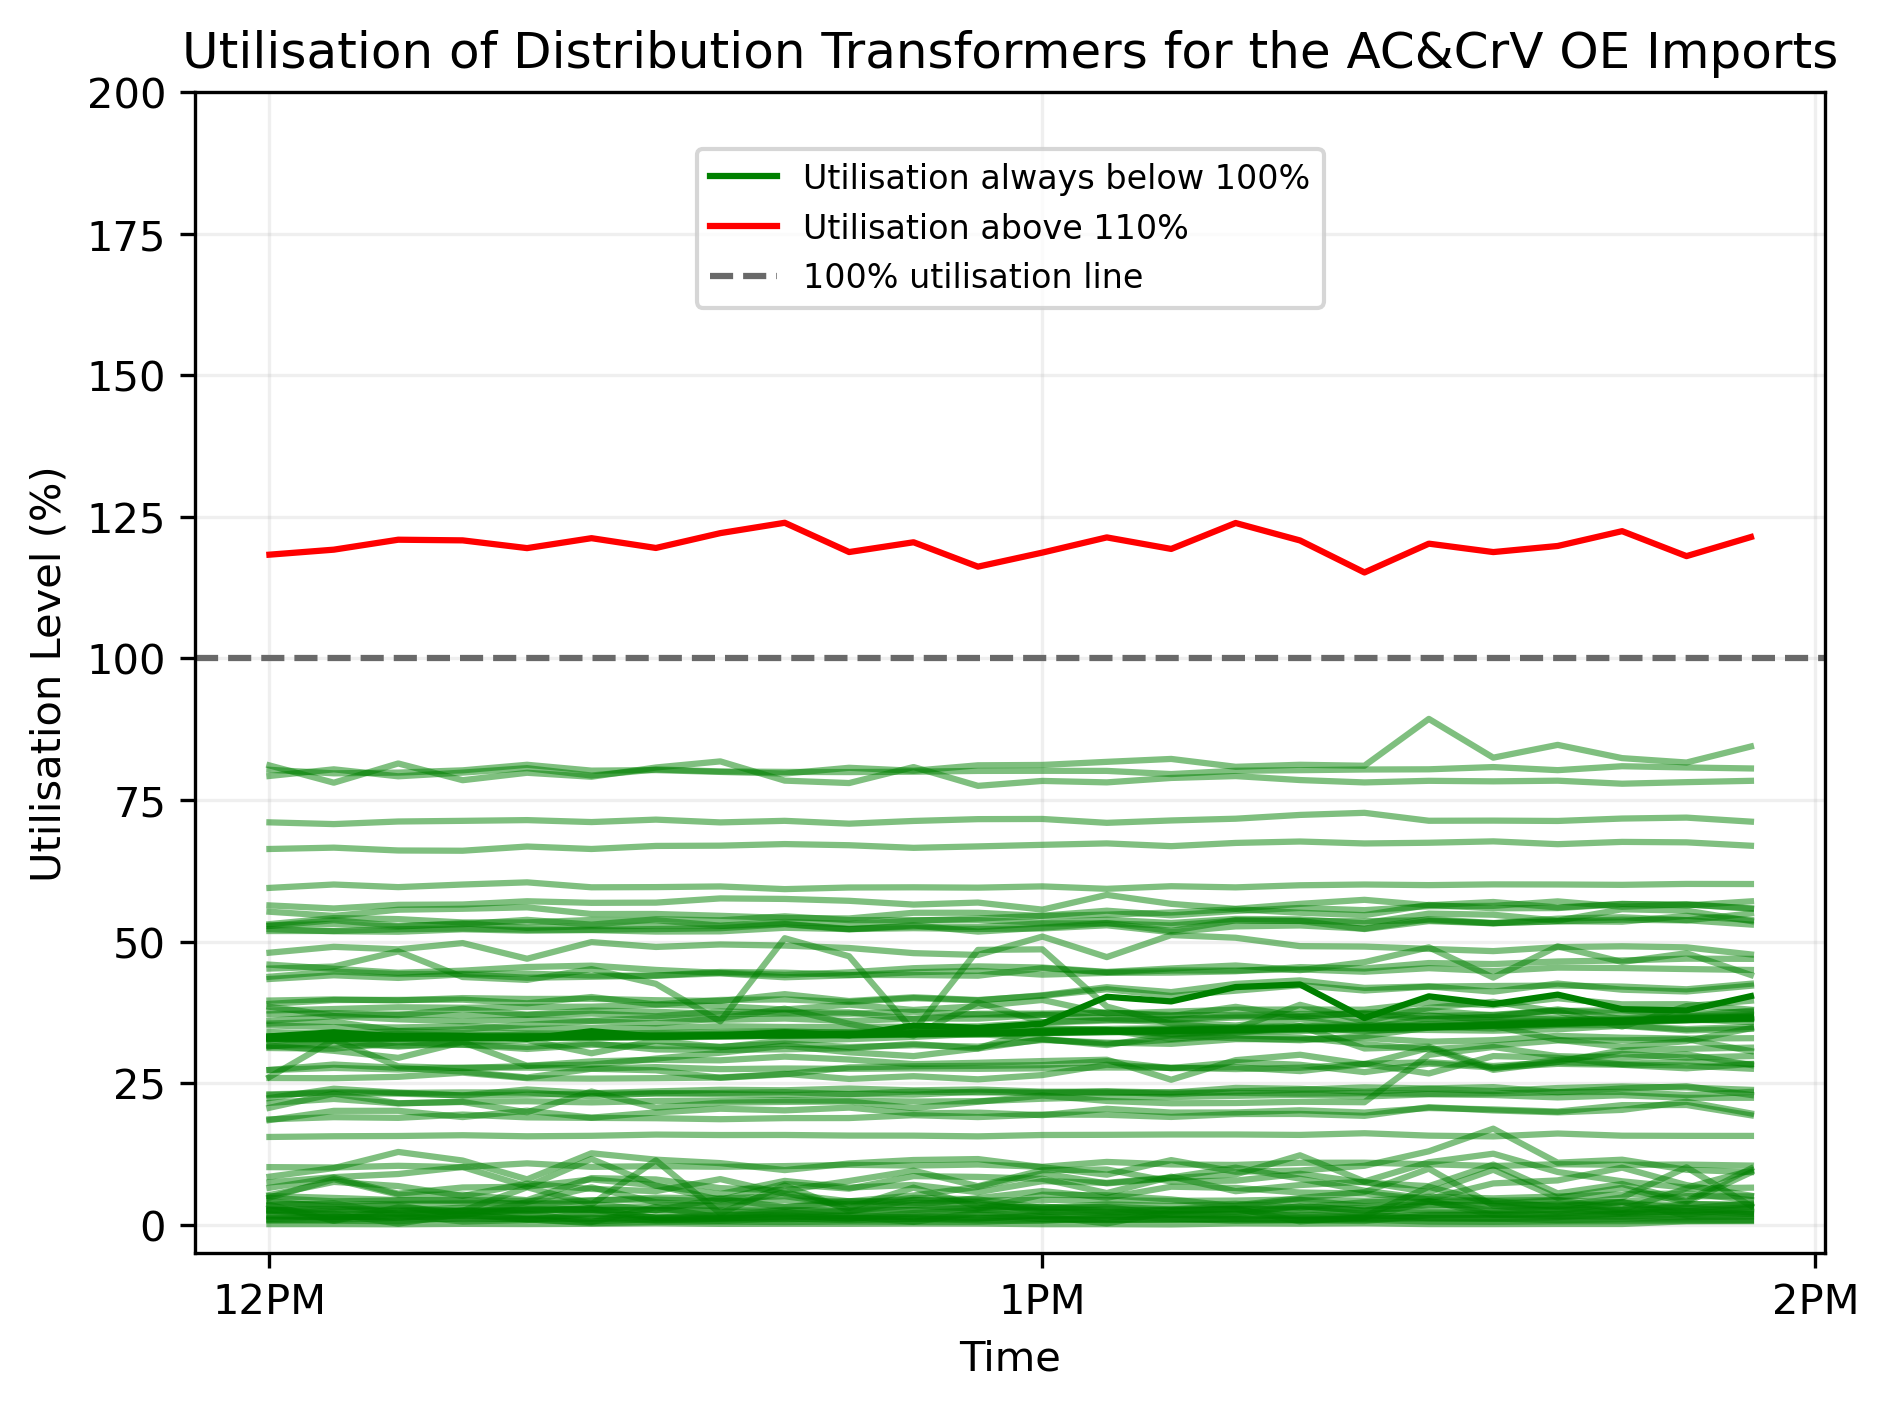

Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:
- The utilisation of the majority (~99%) of the distribution transformers are always within the required limits.
- 1 distribution transformers go above the 110% utilisation.


In [26]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Plot utilisation of all distribution transformers
    x = range(24)
    y1 = save_lvtx_util
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilisation of Distribution Transformers for the AC&CrV OE Imports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        if (y1[itx] <= 100.49).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[itx][:24], color='green', alpha=1, label='Utilisation always below 100%') 
                green_count += 1
            else:
                plt.plot(x, y1[itx][:24], color='green', alpha=0.5)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 100.49).any() and (y1[itx] <= 110.49).all():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[itx][:24], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                yellow_count += 1
            else:
                plt.plot(x, y1[itx][:24], color='gold', alpha=0.75)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 110.49).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[itx][:24], color='red', alpha=1, label='Utilisation above 110%') 
                red_count =+ 1
            else:
                plt.plot(x, y1[itx][:24], color='red', alpha=0.75)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 200)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.8, 0, 0))
    plt.tight_layout()
    plt.show()

    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:')
    print('- The utilisation of the majority (~99%) of the distribution transformers are always within the required limits.')
    print('- 1 distribution transformers go above the 110% utilisation.')
    
    

    
if full_simulation == 1: # full three days simulation (simulates 72h)
    # Plot utilisation of all distribution transformers
    x = range(num_time_steps*num_days)
    y1 = save_lvtx_util
    red_count = 0
    yellow_count = 0
    green_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
        
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilisation of Distribution Transformers for the AC&CrV OE Imports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for itx in range(num_distr_tx):
        if (y1[itx] <= 100.49).all():
            count_green_temp += 1
            if green_count == 0:
                plt.plot(x, y1[itx], color='green', alpha=1, label='Utilisation always below 100%') 
                green_count += 1
            else:
                plt.plot(x, y1[itx], color='green', alpha=0.5)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 100.49).any() and (y1[itx] <= 110.49).all():
            count_yellow_temp += 1
            if yellow_count == 0:
                plt.plot(x, y1[itx], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                yellow_count += 1
            else:
                plt.plot(x, y1[itx], color='gold', alpha=0.75)
    for itx in range(num_distr_tx):    
        if (y1[itx] > 110.49).any():
            count_red_temp += 1
            if red_count == 0:
                plt.plot(x, y1[itx], color='red', alpha=1, label='Utilisation above 110%') 
                red_count =+ 1
            else:
                plt.plot(x, y1[itx], color='red', alpha=0.75)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 160)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.8, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for the three simulated days (summer):')
    print('- The utilisation of the majority (~95%) of the distribution transformers are always within the required limits.')
    print('- Only 4 distribution transformers go above the 100% utilisation but do not go beyond 110%, which is perfectly acceptable under real operational conditions.')
    print('- The Asset Capacity & Critical Voltage OE Imports with Integrated MV-LV Calculation could maintain all distribution transformers under acceptable utilisation levels.')

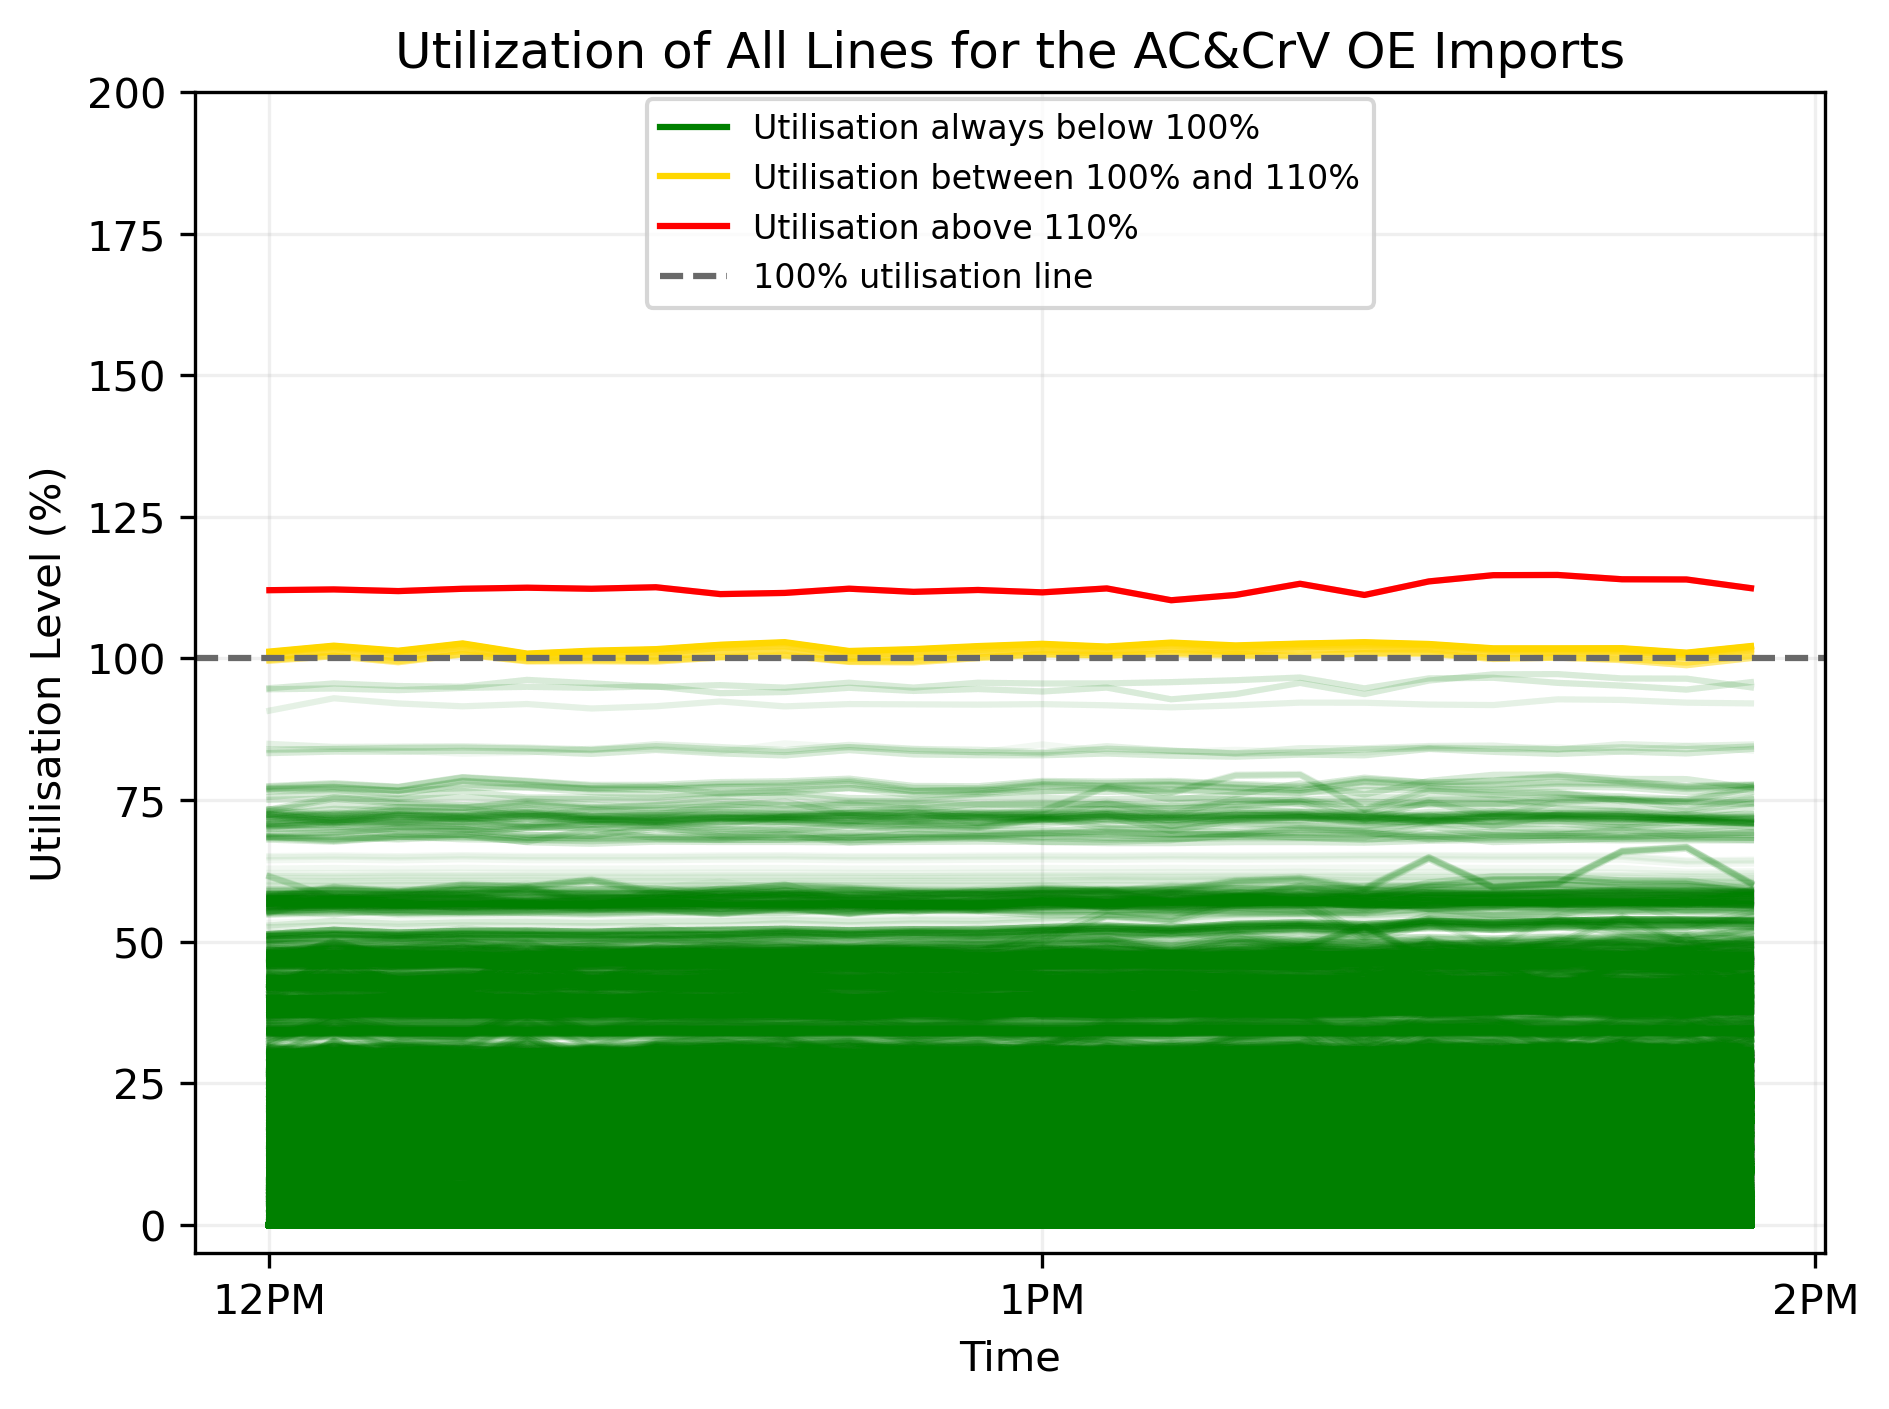

Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:
- The utilisation of almost all lines (more than 99%) are always within the required limits.
- Extremely few lines (less than 0.1%) go above the 100% utilisation but do not go beyond 110%, which is acceptable under real operational conditions.
- Extremely few lines (less than 0.1%) go above the 110% utilisation, and some of them can stay above this value for a long time, which can be concerning. However, it is only 1 line.


In [30]:
if full_simulation == 0: # simplified simulation (2h of the first day)
    # Plot utilisation of all MV and LV lines
    x = range(24)
    y1 = save_lines_util
    green_count = 0
    yellow_count = 0
    red_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilization of All Lines for the AC&CrV OE Imports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for iln in range(len(y1)):
        for iph in range(3):
            if (y1[iln, iph, :] <= 100.49).all():
                count_green_temp += 1
                if green_count == 0:
                    plt.plot(x, y1[iln, iph, :24], color='green', alpha=1, label='Utilisation always below 100%') 
                    green_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :24], color='green', alpha=0.05)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 100.49).any() and (y1[iln, iph, :] <= 110.49).all():
                count_yellow_temp += 1
                if yellow_count == 0:
                    plt.plot(x, y1[iln, iph, :24], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                    yellow_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :24], color='gold', alpha=0.2)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 110.49).any():
                count_red_temp += 1
                if red_count == 0:
                    plt.plot(x, y1[iln, iph, :24], color='red', alpha=1, label='Utilisation above 110%') 
                    red_count =+ 1
                else:
                    plt.plot(x, y1[iln, iph, :24], color='red', alpha=0.2)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 200)
    ax.set_xticks([0, 12, 24])
    ax.set_xticklabels(['12PM', '1PM', '2PM'])
    plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.8, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for 2h of the first day:')
    print('- The utilisation of almost all lines (more than 99%) are always within the required limits.')
    print('- Extremely few lines (less than 0.1%) go above the 100% utilisation but do not go beyond 110%, which is acceptable under real operational conditions.')
    print('- Extremely few lines (less than 0.1%) go above the 110% utilisation, and some of them can stay above this value for a long time, which can be concerning. However, it is only 1 line.')
    
    
    

if full_simulation == 1: # full three days simulation (simulates 72h)
    # Plot utilisation of all MV and LV lines
    x = range(num_time_steps*num_days)
    y1 = save_lines_util
    green_count = 0
    yellow_count = 0
    red_count = 0

    count_green_temp = 0
    count_yellow_temp = 0
    count_red_temp = 0    
    
    plt.figure(dpi=300)
    ax = plt.axes()
    plt.title("Utilization of All Lines for the AC&CrV OE Imports")
    plt.ylabel("Utilisation Level (%)")
    plt.xlabel("Time")
    for iln in range(len(y1)):
        for iph in range(3):
            if (y1[iln, iph, :] <= 100.49).all():
                count_green_temp += 1
                if green_count == 0:
                    plt.plot(x, y1[iln, iph, :], color='green', alpha=1, label='Utilisation always below 100%') 
                    green_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :], color='green', alpha=0.05)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 100.49).any() and (y1[iln, iph, :] <= 110.49).all():
                count_yellow_temp += 1
                if yellow_count == 0:
                    plt.plot(x, y1[iln, iph, :], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                    yellow_count += 1
                else:
                    plt.plot(x, y1[iln, iph, :], color='gold', alpha=0.2)
    for iln in range(len(y1)):    
        for iph in range(3):
            if (y1[iln, iph, :] > 110.49).any():
                count_red_temp += 1
                if red_count == 0:
                    plt.plot(x, y1[iln, iph, :], color='red', alpha=1, label='Utilisation above 110%') 
                    red_count =+ 1
                else:
                    plt.plot(x, y1[iln, iph, :], color='red', alpha=0.2)
    plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
    plt.grid(alpha=0.2)
    plt.ylim(-5, 200)
    ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
    ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
    plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.8, 0, 0))
    plt.tight_layout()
    plt.show()
    
    print('Comments about the figure above, which considers low-mid penetration (15%) of flexible customers for the three simulated days (summer):')
    print('- The utilisation of the large majority (more than 99%) of all lines are always within the required limits.')
    print('- Extremely few lines (less than 0.1%) go above the 100% utilisation but do not go beyond 110%, which is acceptable under real operational conditions.')
    print('- Extremely few lines (less than 0.1%) go above the 110% utilisation, and some of them can stay above this value for a long time, which can be concerning. This happens because of simplifications on the assumed location of flexible customers (i.e., to which LV feeder it is connected to and to which phase).')
    print('- The Asset Capacity & Critical Voltage OE Imports with Integrated MV-LV Calculation could maintain the majority of lines under acceptable utilisation levels, while few LV lines were above 110% for long periods.')

<span style="color:red">**<u>Note 1</u>.</span>** These metrics can be used to do comparisons with other OE implementations, but not all metrics used in the project are calculated here. For a complete performance analysis please refer to the final report of the project.

<span style="color:red">**<u>Note 2</u>.</span>** The default configuration for time steps and OE reduction step used here is different from the one used for the report. Here, these configurations were adapted to be consistent with the Ideal OE repository (needed to speed up simulations). Note that you can reverse then to the original (same as in the report). For this, you should follow the instructions previously presented in this Jupyter notebook.